# Gun Violence Capstone Project

# Machine Learning

The goal of this notebook is to create a supervised machine learning algorithm that can predict the number of people killed/injured as a result of gun violence based on a number of feature variables.

**0. Begin by importing relevant packages and data wrangling code.**

In [1]:
# Packages
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import normalize

In [2]:
df = pd.read_csv('Downloads/Data/gun-violence-data_01-2013_03-2018.csv', parse_dates=['date'])
df.drop(['incident_id','incident_url','source_url','incident_url_fields_missing','location_description','notes','participant_name','participant_relationship', 'sources', 'participant_status', 'address', 'latitude', 'longitude','participant_type','participant_age', 'gun_stolen', 'n_guns_involved'], axis = 1, inplace = True)
df.dropna(how = 'any', subset = ['incident_characteristics', 'state_house_district', 'congressional_district', 'state_senate_district'], inplace = True)
df['participant_age_group'].fillna('0::Unknown', inplace = True)
def agegroup_cleanup(row):
    agegroup_row_values = []
    agegroup_row = str(row).split("||")
    for x in agegroup_row :
        agegroup_row_value = str(x).split("::")
        if len(agegroup_row_value) > 1 :
            agegroup_row_values.append(agegroup_row_value[1])
    return agegroup_row_values
agegroupvalues = df.participant_age_group.apply(agegroup_cleanup)
df["agegroup_child"] = agegroupvalues.apply(lambda x: x.count("Child 0-11"))
df["agegroup_teen"] = agegroupvalues.apply(lambda x: x.count("Teen 12-17"))
df["agegroup_adult"] = agegroupvalues.apply(lambda x: x.count("Adult 18+"))
df = df[df['incident_characteristics'].str.contains('Non-Shooting Incident') == False]
df['date'] = pd.to_datetime(df.date)
df['year'] = df.date.dt.year
df['month'] = df.date.dt.month
df['monthday'] = df.date.dt.day
df['weekday'] = df.date.dt.weekday
city_list = df['city_or_county'].value_counts().head(15).index.tolist()
df = df[df['city_or_county'].apply(lambda x: x in city_list)]
df['participant_gender'].fillna('0::Unknown', inplace = True)
def gender_cleanup(row):
    gender_row_values = []
    gender_row = str(row).split("||")
    for x in gender_row :
        gender_row_value = str(x).split("::")
        if len(gender_row_value) > 1 :
            gender_row_values.append(gender_row_value[1])   
    return gender_row_values
participant_genders = df.participant_gender.apply(gender_cleanup)
df["participant_gender_total"] = participant_genders.apply(lambda x: len(x))
df["participant_gender_male"] = participant_genders.apply(lambda x: x.count("Male"))
df["participant_gender_female"] = participant_genders.apply(lambda x: x.count("Female"))
df["participant_gender_unknown"] = participant_genders.apply(lambda x: x.count("Unknown"))
big_text = "||".join(df['incident_characteristics']).split("||")
df['gun_type'].fillna('0::Unknown', inplace = True)
gt = df.groupby(by=['gun_type']).agg({'n_killed': 'sum', 'n_injured' : 'sum', 'state' : 'count'}).reset_index().rename(columns={'state':'count'})
results = {}
for i, each in gt.iterrows():
    wrds = each['gun_type'].split("||")
    for wrd in wrds:
        if "Unknown" in wrd:
            continue
        wrd = wrd.replace("::",":").replace("|1","")
        gtype = wrd.split(":")[1]
        if gtype not in results: 
            results[gtype] = {'killed' : 0, 'injured' : 0, 'used' : 0}
        results[gtype]['killed'] += each['n_killed']
        results[gtype]['injured'] +=  each['n_injured']
        results[gtype]['used'] +=  each['count']
gun_names = list(results.keys())
used = [each['used'] for each in list(results.values())]
killed = [each['killed'] for each in list(results.values())]
injured = [each['injured'] for each in list(results.values())]
incident_dict = {}
incident_dict2 = {}
for i, x in df['incident_characteristics'].iteritems():
    x = x.split('|')
    incident_dict[i] = x[0]
    if len(x)>1:
        if x[1] == '':
            incident_dict2[i] = x[2]
        else:
            incident_dict2[i] = x[1]
df2 = pd.DataFrame([incident_dict, incident_dict2])
df2 = df2.transpose()
df = pd.concat([df, df2], axis = 'columns')
df.rename(columns={0:'primary_characteristic', 1: 'secondary_characteristic'}, inplace=True)
df['city_or_county'] = pd.Categorical(df.city_or_county)
df['mapped_cities'] = df.city_or_county.cat.codes
df['primary_characteristic'] = pd.Categorical(df.primary_characteristic)
df['mapped_primary'] = df.primary_characteristic.cat.codes
df['secondary_characteristic'] = pd.Categorical(df.secondary_characteristic)
df['mapped_secondary'] = df.secondary_characteristic.cat.codes

**1. Select the feature and response variables**

- From performing inferential statistics and checking correlation between variables, we know which features we want to select to predict the number of people killed (n_killed) and the number of people injured (n_injured). 


- In the inferential statistics notebook, we've also turned the age-group and participant-gender columns into its own separate categorical columns. For age-group, we had 3 columns for child (people aged 0-11), teen (people aged 12-17) and adult (people aged 18+) and each one counted the number of times a person of that age group was part of the incident. For participant-gender, we had 3 columns for male, female and unknown (cases where the gender was unknown).


- We also used the pandas function pd.Categorical() to transform the columns 'city_or_county', 'primary_characteristics' and 'secondary_characteristics' into Categorical columns where each value is represented by numbers. Ex. Chicago is no longer a string called 'Chicago' and is instead represented by the number 1.


- Through these steps, we've ensured that the feature variables will be numerical while retaining its original information.

In [3]:
# Select feature variables and store them as a numpy array
X = df[['n_injured', 
        'congressional_district', 
        'state_house_district','state_senate_district',
        'agegroup_child','agegroup_adult','agegroup_teen',
        'year','month','monthday','weekday',
        'participant_gender_male','participant_gender_female','participant_gender_unknown',
        'mapped_primary','mapped_cities','mapped_secondary'
       ]]
X_col = X.columns
X = X.values

X2 = df[['n_killed', 
        'congressional_district', 
        'state_house_district','state_senate_district',
        'agegroup_child','agegroup_adult','agegroup_teen',
        'year','month','monthday','weekday',
        'participant_gender_male','participant_gender_female','participant_gender_unknown',
        'mapped_primary','mapped_cities','mapped_secondary'
       ]]
X2_col = X2.columns
X2 = X2.values

# Select response variables and store them as a numpy array
y = df['n_killed'].values
y2 = df['n_injured'].values

- (Note: We will be creating 2 sets of feature and response variables in order to test for the number of deaths and number of injuries seperately.)

**2. Pre-processing the Data**

- Before we dive right into creating our classifiers, we will need to pre-process the data beyond just filling in missing data and converting categorical columns. An important aspect of machine learning is the concept of standardization, where we determine whether or not the features should be scaled in a similar fashion or if they're better left untouched. Let's begin by observing the mean and standard deviation of the features before and after applying the scale function.

In [4]:
X_scaled = scale(X)
print("Mean of Unscaled Features (n_killed): \n{0:.4f}".format(np.mean(X))) 
print("\nStandard Deviation of Unscaled Features (n_killed): \n{0:.4f}".format(np.std(X)))
print("\nMean of Scaled Features (n_killed): \n{0:.4f}".format(np.mean(X_scaled))) 
print("\nStandard Deviation of Scaled Features (n_killed): \n{0:.4f}".format(np.std(X_scaled)))

Mean of Unscaled Features (n_killed): 
126.8560

Standard Deviation of Unscaled Features (n_killed): 
472.4881

Mean of Scaled Features (n_killed): 
0.0000

Standard Deviation of Scaled Features (n_killed): 
1.0000


In [5]:
X_scaled = scale(X2)
print("Mean of Unscaled Features (n_injured): \n{0:.4f}".format(np.mean(X2))) 
print("\nStandard Deviation of Unscaled Features (n_injured): \n{0:.4f}".format(np.std(X2)))
print("\nMean of Scaled Features (n_injured): \n{0:.4f}".format(np.mean(X_scaled))) 
print("\nStandard Deviation of Scaled Features (n_injured): \n{0:.4f}".format(np.std(X_scaled)))

Mean of Unscaled Features (n_injured): 
126.8277

Standard Deviation of Unscaled Features (n_injured): 
472.4956

Mean of Scaled Features (n_injured): 
0.0000

Standard Deviation of Scaled Features (n_injured): 
1.0000


- As we can see, there was a relatively large standard deviation among the features. This implies that the scaling between the columns was vastly different from one another. To prove this point, we can take a peek at a few features whose scaling are totally different.

In [6]:
df[['n_injured','state_house_district','agegroup_adult','mapped_primary']].head()

,n_injured,state_house_district,agegroup_adult,mapped_primary
7,5,93.0,0,32
11,3,76.0,1,32
15,5,84.0,5,32
17,4,25.0,6,32
18,4,93.0,7,32


- Whereas n_injured mostly has values ranging from 0 to 5, a feature like state_house_district has values jumping all over the place due to its categorical nature. It would be an egregious mistake to assume that the data does not need scaling. 

**3. Using Linear Regression with Regularization (Lasso and Ridge)**

- Let's begin by using the most standard regression classifier: **Linear Regression**. It's very simple since it does not require any hyperparameters. 

- First we will create a baseline using the DummyRegressor function and set the strategy to 'mean'. This will give us a way to check how accurate the predictions are.

In [7]:
# Finding the baseline for the dataset.
# Begin by creating the pipeline steps. Start with scaling the data via StandardScaler and then the DummyRegressor estimator
steps = [('scaler', StandardScaler()), ('clf', DummyRegressor(strategy='mean'))]
pipeline = Pipeline(steps)
# Create the train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
# Fit the data into the pipeline
pipeline.fit(X_train,y_train)
# Predict the response variables using the test data
y_pred = pipeline.predict(X_test)

# Computing the baseline R-squared
print('Baseline R-squared (n_killed): {0:.4f}'.format(pipeline.score(X_test, y_test)))

#Computing the baseline RMSE
y_pred = pipeline.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Baseline Root Mean Squared Error (n_killed): {0:.4f}'.format(rmse))
cv_scores = cross_val_score(pipeline,X,y,cv=10)
print("Baseline Average 10-Fold CV Score (n_killed): {0:.4f}".format(np.mean(cv_scores)))

# Repeat the steps for n_injured
steps = [('scaler', StandardScaler()), ('clf', DummyRegressor(strategy='mean'))]
pipeline = Pipeline(steps)
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size = 0.3, random_state = 23)
pipeline.fit(X_train,y_train)
y_pred = pipeline.predict(X_test)
print('\nBaseline R-squared (n_injured): {0:.5f}'.format(pipeline.score(X_test, y_test)))
y_pred = pipeline.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Baseline Root Mean Squared Error (n_injured): {0:.4f}'.format(rmse))
cv_scores = cross_val_score(pipeline,X2,y2,cv=10)
print("Baseline Average 10-Fold CV Score (n_injured): {0:.4f}".format(np.mean(cv_scores)))

Baseline R-squared (n_killed): -0.0001
Baseline Root Mean Squared Error (n_killed): 0.5067
Baseline Average 10-Fold CV Score (n_killed): -0.0053

Baseline R-squared (n_injured): -0.00002
Baseline Root Mean Squared Error (n_injured): 0.7654
Baseline Average 10-Fold CV Score (n_injured): -0.0126


- Our baseline r-squared for n_killed is -0.0001 and our baseline RMSE is 0.5067. 


- Our baseline r-squared for n_injured is -0.00002 and our baseline RMSE is 0.7653. 


- Although the r-squared seems very bad, it's important to remember it only serves as a baseline against which we can compare the results of our models.

In [8]:
steps = [('scaler', StandardScaler()), ('reg', LinearRegression())]
pipeline = Pipeline(steps)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# Measure the accuracy of the predictions by finding the R-squared and root mean squared error
print("R-squared (n_killed): {0:.4f}".format(pipeline.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error (n_killed): {0:.4f}".format(rmse))
# Use Cross-Validation to better understand the model's performance using k-folds
cv_scores = cross_val_score(pipeline,X,y,cv=10)
print("Average 10-Fold CV Score (n_killed): {0:.4f}".format(np.mean(cv_scores)))

# Repeat the steps for n_injured
steps = [('scaler', StandardScaler()), ('reg', LinearRegression())]
pipeline2 = Pipeline(steps)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size = 0.3, random_state = 1)
pipeline2.fit(X_train2, y_train2)
y_pred2 = pipeline2.predict(X_test2)
print("\nR-squared (n_injured): {0:.4f}".format(pipeline2.score(X_test2, y_test2)))
rmse2 = np.sqrt(mean_squared_error(y_test2, y_pred2))
print("Root Mean Squared Error (n_injured): {0:.4f}".format(rmse2))
cv_scores2 = cross_val_score(pipeline,X2,y2,cv=10)
print("Average 10-Fold CV Score (n_injured): {0:.4f}".format(np.mean(cv_scores2)))

R-squared (n_killed): 0.3835
Root Mean Squared Error (n_killed): 0.3924
Average 10-Fold CV Score (n_killed): 0.3711

R-squared (n_injured): 0.4747
Root Mean Squared Error (n_injured): 0.5719
Average 10-Fold CV Score (n_injured): 0.4547


- By comparing the results of the linear regression to the n_killed baseline, we can see that the r-squared of 0.3834 and RMSE of 0.3924 are better than the baseline.


- Similarly for n_injured, the r-squared of 0.4746 and RMSE of 0.5718 are better than the baseline.


- Let's plot the predicted versus the actual response values so that we can see how well the linear regression model performed from a visual standpoint.

In [9]:
#reg_coef = pipeline.named_steps['reg'].coef_
#reg_coef2 = pipeline2.named_steps['reg'].coef_

#sns.set()
#f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (15,15))
#ax1.scatter(y_pred,y_test,marker='.')
#ax1.set_title('Predicted vs Actual (n_killed)')
#ax1.set_xlabel('Predicted n_killed values')
#ax1.set_ylabel('Actual n_killed values')

#ax2.scatter(y_pred2,y_test2,marker='.')
#ax2.set_title('Predicted vs Actual (n_injured)')
#ax2.set_xlabel('Predicted n_injured values')
#ax2.set_ylabel('Actual n_injured values')

#ax3.plot(range(len(X_col)),reg_coef)
#ax3.set_title('Feature Coefficients (n_killed)')
#ax3.set_xticklabels(X_col, rotation = 60)
#ax3.set_xlabel('Feature Variables (n_killed)')
#ax3.set_ylabel('Coefficient Values (n_killed)')

#ax4.plot(range(len(X2_col)),reg_coef2)
#ax4.set_title('Feature Coefficients (n_injured)')
#ax4.set_xlabel('Feature Variables (n_injured)')
#ax4.set_ylabel('Coefficient Values (n_injured)')

#plt.tight_layout()

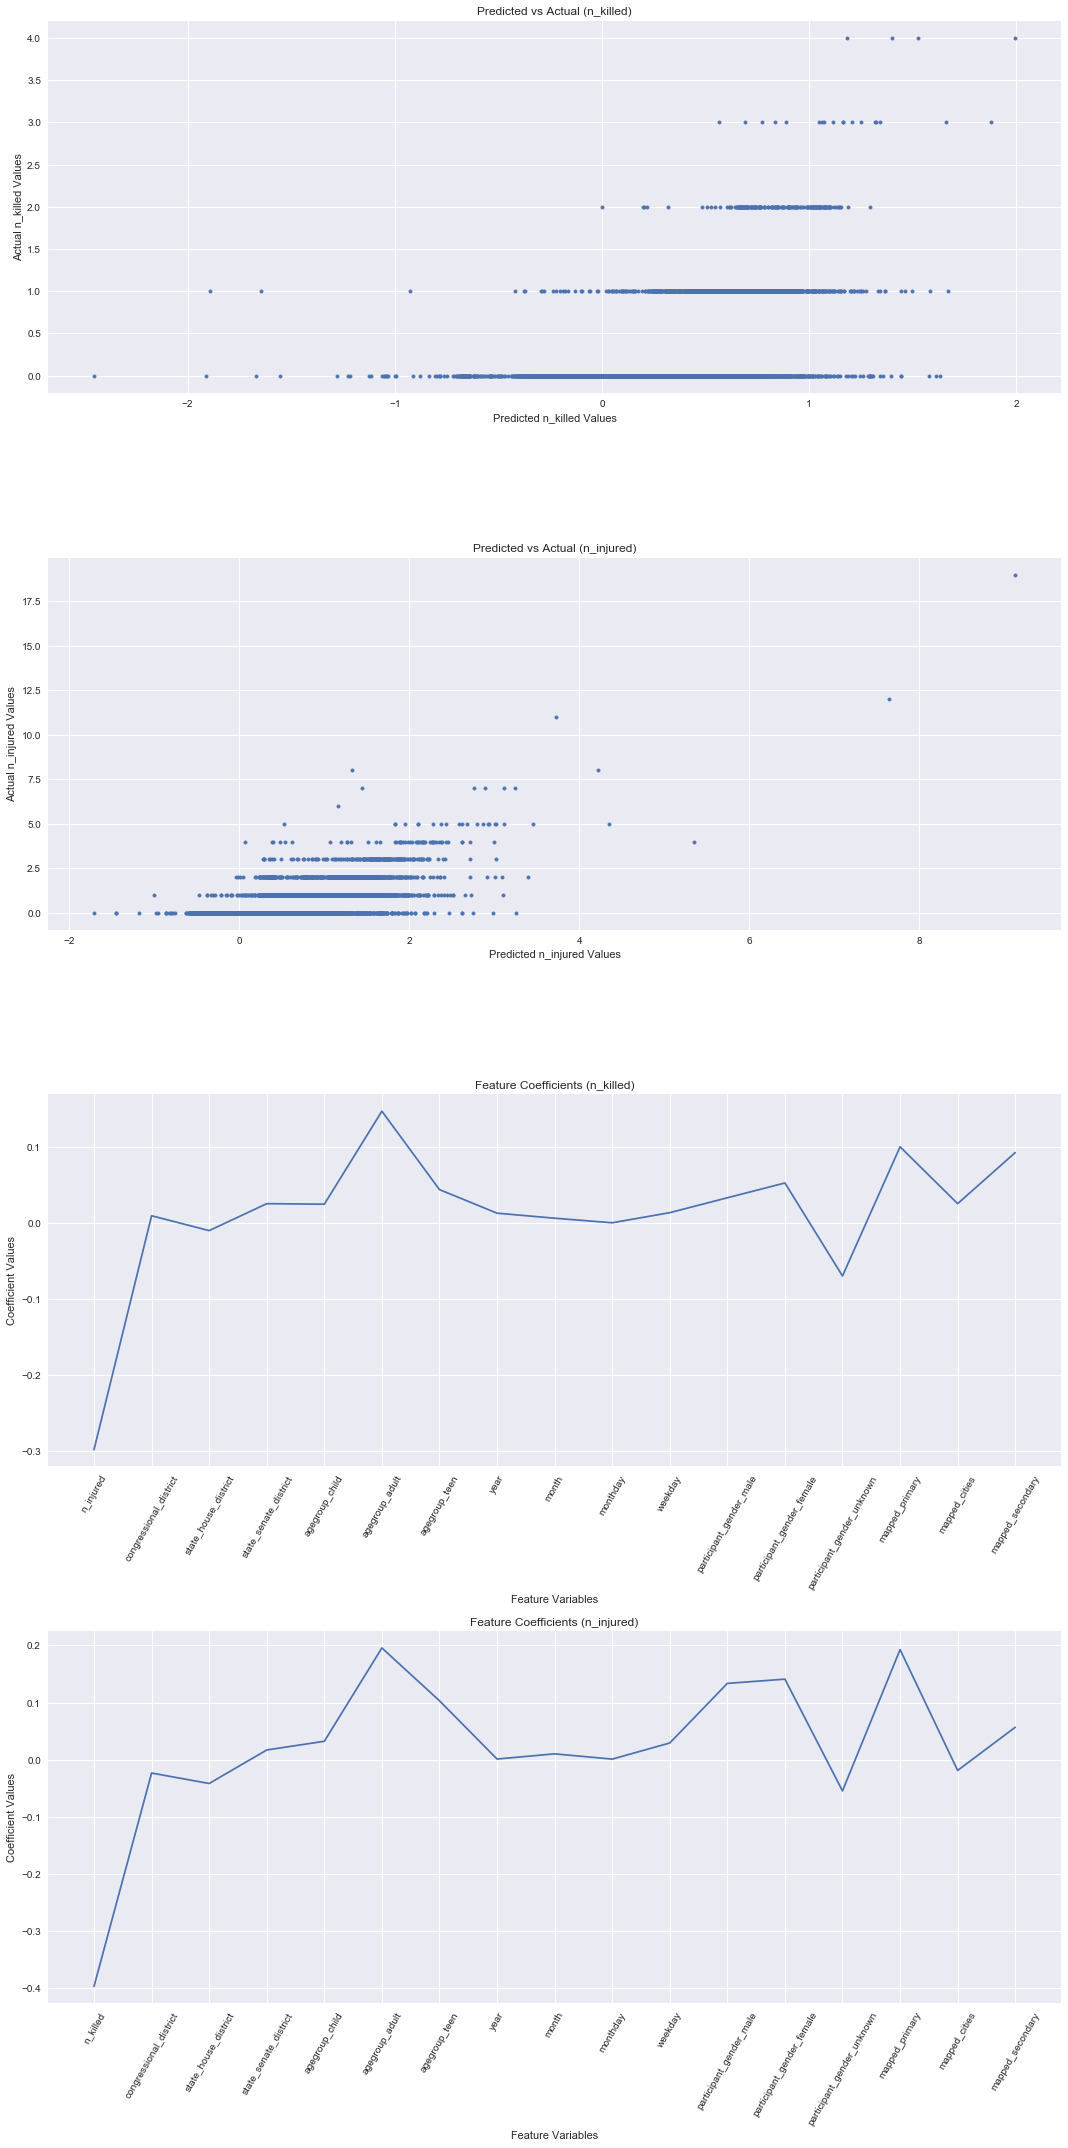

In [10]:
# Use a scatter plot to display the predicted vs actual values
sns.set()
fig = plt.figure(figsize = (15,30))
_ = plt.subplot(4,1,1)
_ = plt.scatter(y_pred,y_test, marker = '.')
_ = plt.xlabel('Predicted n_killed Values')
_ = plt.ylabel('Actual n_killed Values')
_ = plt.title('Predicted vs Actual (n_killed)')

# Do the same for n_injured
_ = plt.subplot(4,1,2)
_ = plt.scatter(y_pred2,y_test2, marker = '.')
_ = plt.xlabel('Predicted n_injured Values')
_ = plt.ylabel('Actual n_injured Values')
_ = plt.title('Predicted vs Actual (n_injured)')

# Plot the coefficients 
reg_coef = pipeline.named_steps['reg'].coef_
_ = plt.subplot(4,1,3)
_ = plt.plot(range(len(X_col)),reg_coef)
_ = plt.xticks(range(len(X_col)),X_col,rotation=60)
_ = plt.xlabel('Feature Variables')
_ = plt.ylabel('Coefficient Values')
_ = plt.title('Feature Coefficients (n_killed)')

# Do the same for n_injured
reg_coef2 = pipeline2.named_steps['reg'].coef_
_ = plt.subplot(4,1,4)
_ = plt.plot(range(len(X2_col)),reg_coef2)
_ = plt.xticks(range(len(X2_col)),X2_col,rotation=60)
_ = plt.xlabel('Feature Variables')
_ = plt.ylabel('Coefficient Values')
_ = plt.title('Feature Coefficients (n_injured)')

_ = plt.tight_layout()

- There are a few takeaways from the predicted vs actual plots. First, the model predicted quite a few negative values for n_killed and n_injured, which is practically impossible. Secondly, the model did not predict any values greater than 2 for n_killed nor did it predict any values greater than 10 for n_injured. It also used floating point numbers instead of only integer values. This shows the limitations of the Linear Regression model.


- The model also set most of the coefficients close to 0. In fact, the only variables that had a coefficient absolute value greater than 0.2 were n_injured when n_killed was the response variable and n_killed when n_injured was the response variable. In both cases, they had negative correlations which implies they have an inverse relationship. On average, if we assume that there is a fixed number of casualties per incident, it makes sense that with more injuries, there will be fewer deaths and vice versa.


- Next, let's use the **Lasso Regularization** and **Ridge Regularization** on the data to help compensate for the possibility of overfitting. For these classifiers, we will be specifying the hyperparameter alpha, which multiples the L1 term. In order to decide which alpha to use, we will be using **GridSearchCV** to iterate over a list of values for alpha. This will return the best alpha value and its "score".

In [11]:
steps = [('scaler', StandardScaler()), ('lasso', Lasso())]
pipeline = Pipeline(steps)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 2)
# Define the parameter values that will be searched
alphas = [0.001, 0.01, 0.1, 1, 10, 100]
# Create the parameter grid
param_grid = {'lasso__alpha':alphas}
# Instantiate the grid search
gscv = GridSearchCV(pipeline, param_grid, scoring = 'r2', n_jobs = -1, cv = 10)
# Fit the training data into the model
gscv.fit(X_train, y_train)
    
# Print the best score and its respective parameters
print('The best score is (n_killed):{0:.4f}'.format(gscv.best_score_))
print('The best parameters are (n_killed):',gscv.best_params_)

# Do the same for n_injured
steps = [('scaler', StandardScaler()), ('lasso', Lasso())]
pipeline2 = Pipeline(steps)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size = 0.3, random_state = 20)
alphas = [0.001, 0.01, 0.1, 1, 10, 100]
param_grid = {'lasso__alpha':alphas}
gscv2 = GridSearchCV(pipeline2, param_grid, scoring = 'r2', n_jobs = -1, cv = 10)
gscv2.fit(X_train2, y_train2)
print('\nThe best score is (n_injured):{0:.4f}'.format(gscv2.best_score_))
print('The best parameters are (n_injured):',gscv2.best_params_)

The best score is (n_killed):0.3912
The best parameters are (n_killed): {'lasso__alpha': 0.001}

The best score is (n_injured):0.4546
The best parameters are (n_injured): {'lasso__alpha': 0.001}


In [12]:
# Now use the best parameters to make predictions using the test data and compute the r-squared/RMSE
# (Note: The attribute .best_estimator_ returns the Lasso classifier with the optimal parameters)
best_lasso = gscv.best_estimator_
y_pred = best_lasso.predict(X_test)
print('R-squared (n_killed): {0:.4f}'.format(best_lasso.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print("Root Mean Squared Error (n_killed): {0:.4f}".format(rmse))
cv_scores = cross_val_score(best_lasso,X,y,cv=10)
print("Average 10-Fold CV Score (n_killed): {0:.4f}".format(np.mean(cv_scores)))

# Do the same for n_injured
best_lasso2 = gscv2.best_estimator_
y_pred2 = best_lasso2.predict(X_test2)
print('\nR-squared (n_injured): {0:.4f}'.format(best_lasso2.score(X_test2, y_test2)))
rmse2 = np.sqrt(mean_squared_error(y_test2,y_pred2))
print("Root Mean Squared Error (n_injured): {0:.4f}".format(rmse2))
cv_scores2 = cross_val_score(best_lasso2,X2,y2,cv=10)
print("Average 10-Fold CV Score (n_injured): {0:.4f}".format(np.mean(cv_scores2)))

R-squared (n_killed): 0.3779
Root Mean Squared Error (n_killed): 0.3911
Average 10-Fold CV Score (n_killed): 0.3710

R-squared (n_injured): 0.4826
Root Mean Squared Error (n_injured): 0.5524
Average 10-Fold CV Score (n_injured): 0.4548


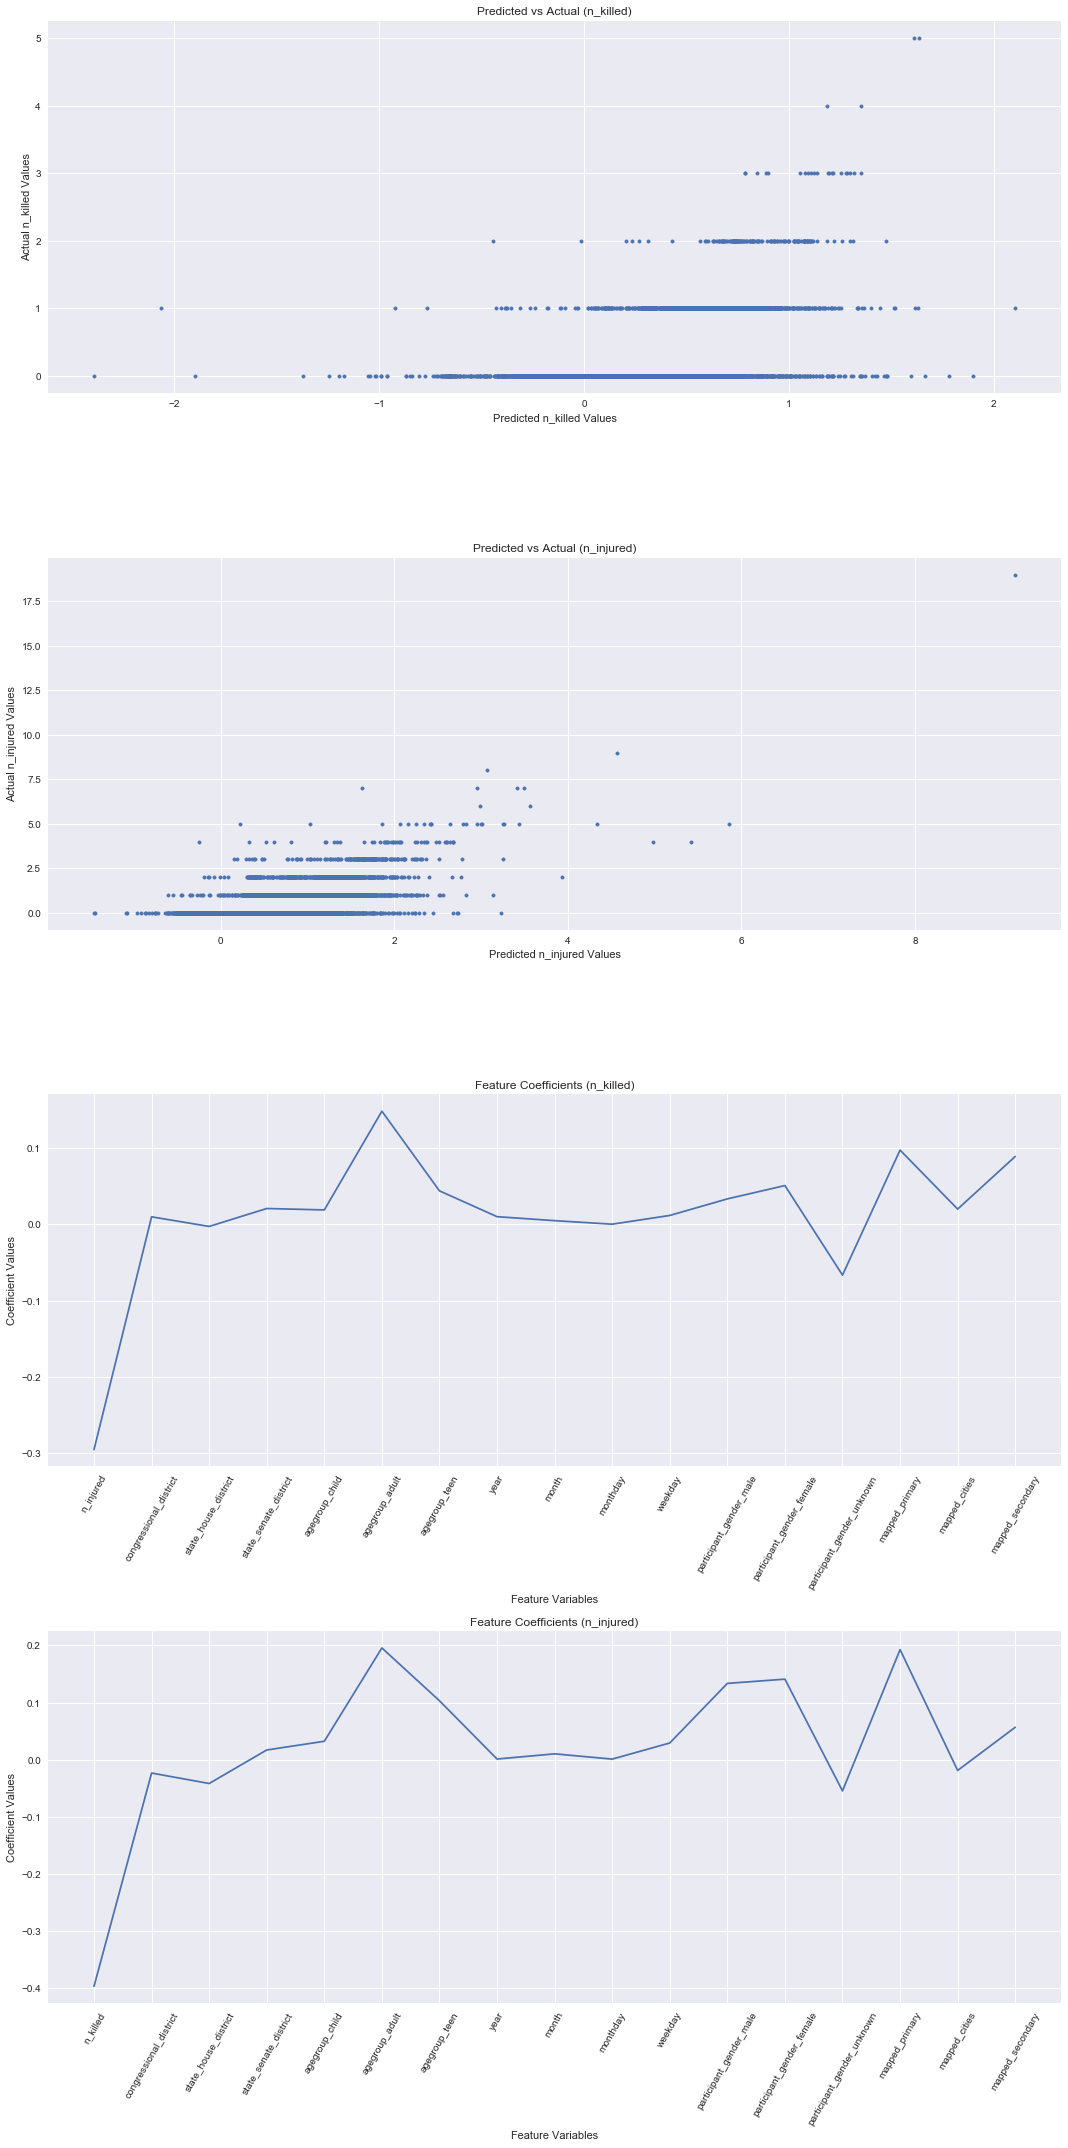

In [13]:
fig = plt.figure(figsize = (15,30))
_ = plt.subplot(4,1,1)
_ = plt.scatter(y_pred,y_test, marker = '.')
_ = plt.xlabel('Predicted n_killed Values')
_ = plt.ylabel('Actual n_killed Values')
_ = plt.title('Predicted vs Actual (n_killed)')

# Do the same for n_injured
_ = plt.subplot(4,1,2)
_ = plt.scatter(y_pred2,y_test2, marker = '.')
_ = plt.xlabel('Predicted n_injured Values')
_ = plt.ylabel('Actual n_injured Values')
_ = plt.title('Predicted vs Actual (n_injured)')

# Plot the coefficients 
lasso_coef = best_lasso.fit(X,y).named_steps['lasso'].coef_
_ = plt.subplot(4,1,3)
_ = plt.plot(range(len(X_col)),lasso_coef)
_ = plt.xticks(range(len(X_col)),X_col,rotation=60)
_ = plt.xlabel('Feature Variables')
_ = plt.ylabel('Coefficient Values')
_ = plt.title('Feature Coefficients (n_killed)')

# Do the same for n_injured
lasso_coef2 = best_lasso2.fit(X2,y2).named_steps['lasso'].coef_
_ = plt.subplot(4,1,4)
_ = plt.plot(range(len(X2_col)),reg_coef2)
_ = plt.xticks(range(len(X2_col)),X2_col,rotation=60)
_ = plt.xlabel('Feature Variables')
_ = plt.ylabel('Coefficient Values')
_ = plt.title('Feature Coefficients (n_injured)')

_ = plt.tight_layout()

- For *n_killed*, the R-squared score for Lasso (0.3778 vs 0.3834) became worse compared to the Linear Regression model *without* any regularization. However, the RMSE (0.3911 vs 0.3924) did slightly improve. Overall, it's still better than the baseline. 


- For *n_injured*, the R-squared score slightly improved for Lasso (0.4825 vs 0.4746) as well as the RMSE score (0.5524 vs 0.5718).


- We will next use the Ridge regularization to see if there are any improvements on the model.

In [14]:
steps = [('scaler', StandardScaler()), ('ridge', Ridge())]
pipeline = Pipeline(steps)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 3)
alphas = [0.001, 0.01, 0.1, 1, 10, 100]
param_grid = {'ridge__alpha':alphas}
gscv = GridSearchCV(pipeline, param_grid, scoring = 'r2', n_jobs = -1, cv = 10)
gscv.fit(X_train, y_train)
print('The best score is (n_killed):{0:.4f}'.format(gscv.best_score_))
print('The best parameters are (n_killed):',gscv.best_params_)

# Do the same for n_injured
steps = [('scaler', StandardScaler()), ('ridge', Lasso())]
pipeline2 = Pipeline(steps)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size = 0.3, random_state = 30)
alphas = [0.001, 0.01, 0.1, 1, 10, 100]
param_grid = {'ridge__alpha':alphas}
gscv2 = GridSearchCV(pipeline2, param_grid, scoring = 'r2', n_jobs = -1, cv = 10)
gscv2.fit(X_train2, y_train2)
print('\nThe best score is (n_injured):{0:.4f}'.format(gscv2.best_score_))
print('The best parameters are (n_injured):',gscv2.best_params_)

The best score is (n_killed):0.3989
The best parameters are (n_killed): {'ridge__alpha': 10}

The best score is (n_injured):0.4465
The best parameters are (n_injured): {'ridge__alpha': 0.001}


In [15]:
best_ridge = gscv.best_estimator_
y_pred = best_ridge.predict(X_test)
print('R-squared (n_killed): {0:.4f}'.format(best_ridge.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print("Root Mean Squared Error (n_killed): {0:.4f}".format(rmse))
cv_scores = cross_val_score(best_ridge,X,y,cv=10)
print("Average 10-Fold CV Score (n_killed): {0:.4f}".format(np.mean(cv_scores)))

# Do the same for n_injured
best_ridge2 = gscv2.best_estimator_
y_pred2 = best_ridge2.predict(X_test2)
print('\nR-squared (n_injured): {0:.4f}'.format(best_ridge2.score(X_test2, y_test2)))
rmse2 = np.sqrt(mean_squared_error(y_test2,y_pred2))
print("Root Mean Squared Error (n_injured): {0:.4f}".format(rmse2))
cv_scores2 = cross_val_score(best_ridge2,X2,y2,cv=10)
print("Average 10-Fold CV Score (n_injured): {0:.4f}".format(np.mean(cv_scores2)))

R-squared (n_killed): 0.3585
Root Mean Squared Error (n_killed): 0.3960
Average 10-Fold CV Score (n_killed): 0.3711

R-squared (n_injured): 0.4931
Root Mean Squared Error (n_injured): 0.5721
Average 10-Fold CV Score (n_injured): 0.4548


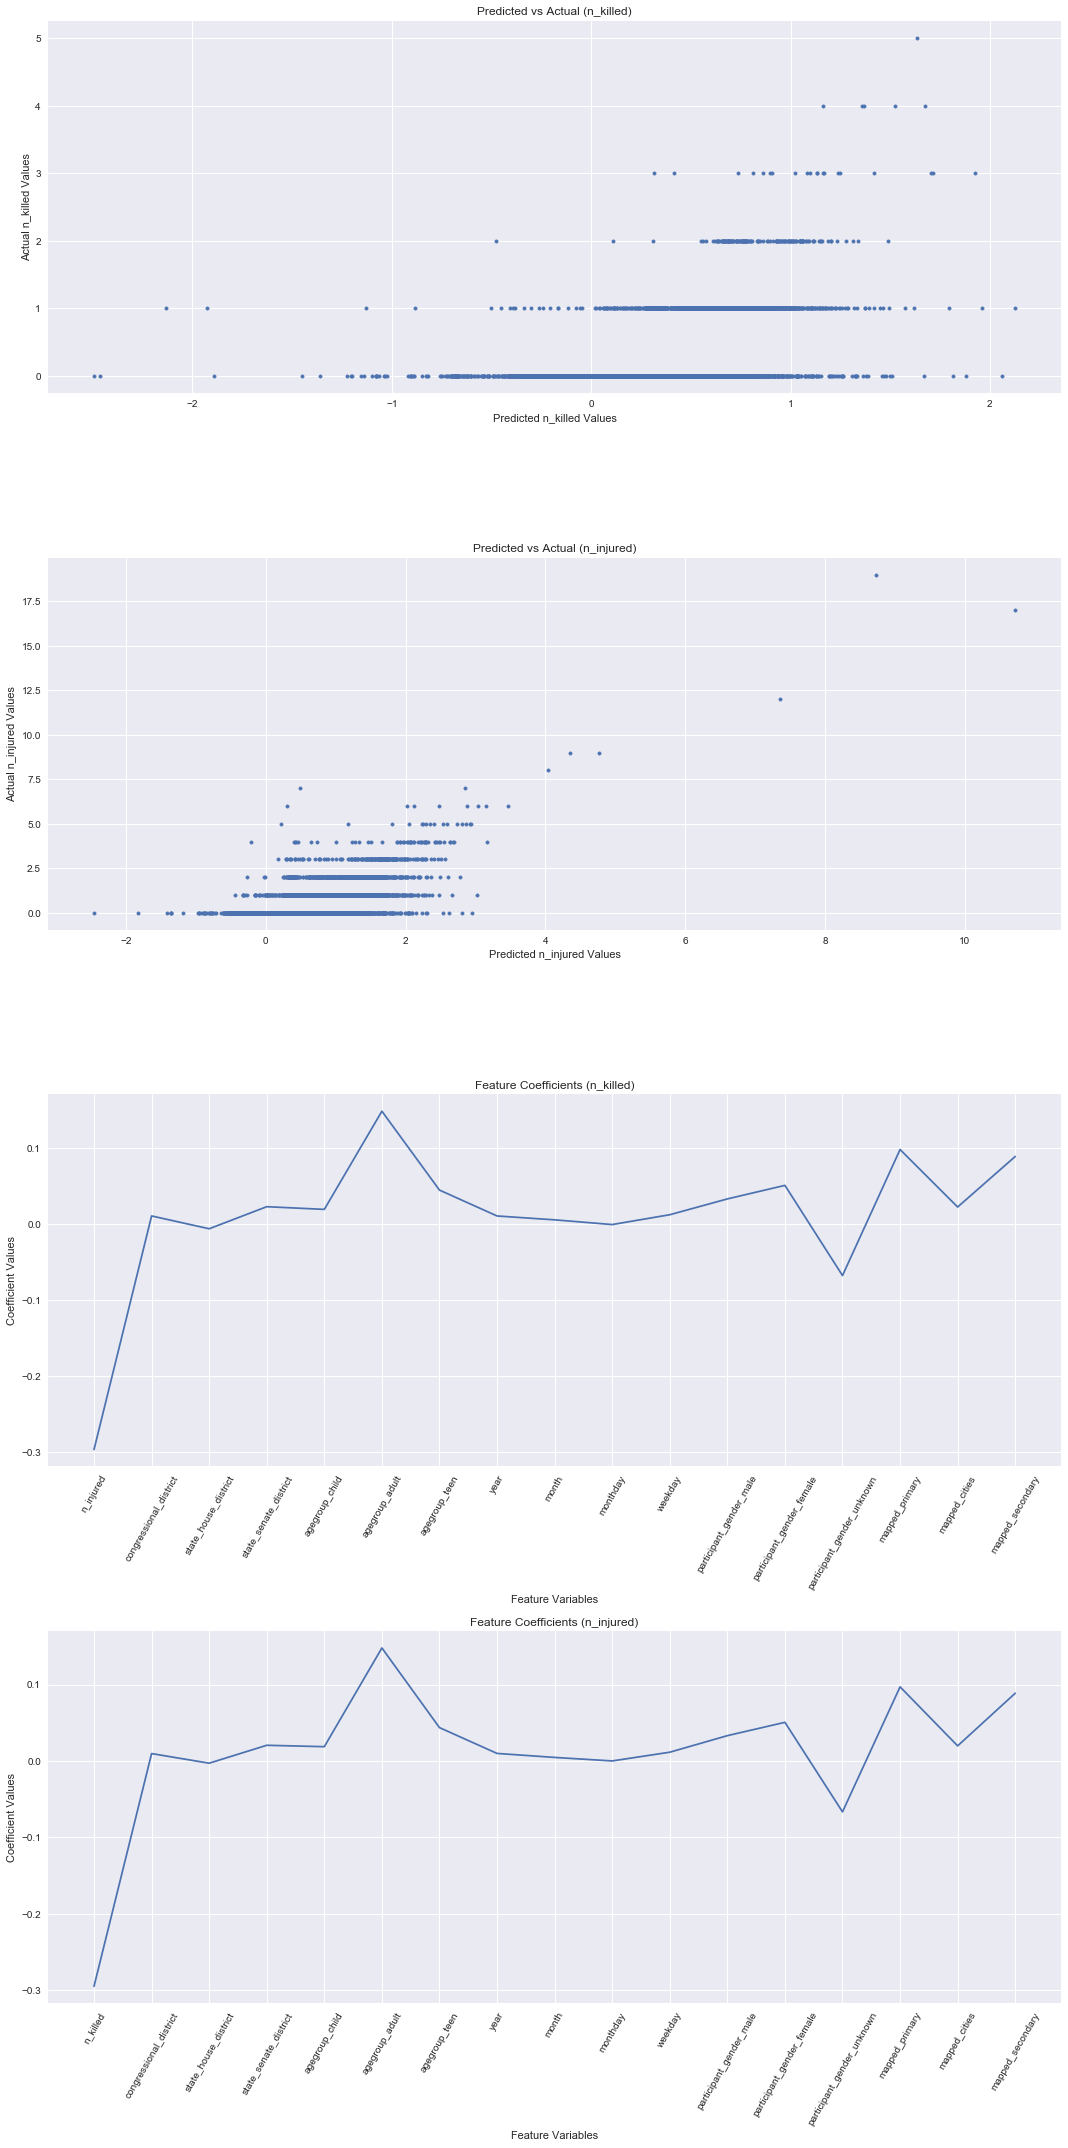

In [16]:
fig = plt.figure(figsize = (15,30))
_ = plt.subplot(4,1,1)
_ = plt.scatter(y_pred,y_test, marker = '.')
_ = plt.xlabel('Predicted n_killed Values')
_ = plt.ylabel('Actual n_killed Values')
_ = plt.title('Predicted vs Actual (n_killed)')

# Do the same for n_injured
_ = plt.subplot(4,1,2)
_ = plt.scatter(y_pred2,y_test2, marker = '.')
_ = plt.xlabel('Predicted n_injured Values')
_ = plt.ylabel('Actual n_injured Values')
_ = plt.title('Predicted vs Actual (n_injured)')

# Plot the coefficients 
ridge_coef = best_ridge.fit(X,y).named_steps['ridge'].coef_
_ = plt.subplot(4,1,3)
_ = plt.plot(range(len(X_col)),ridge_coef)
_ = plt.xticks(range(len(X_col)),X_col,rotation=60)
_ = plt.xlabel('Feature Variables')
_ = plt.ylabel('Coefficient Values')
_ = plt.title('Feature Coefficients (n_killed)')

# Do the same for n_injured
ridge_coef2 = best_ridge2.fit(X,y).named_steps['ridge'].coef_
_ = plt.subplot(4,1,4)
_ = plt.plot(range(len(X2_col)),ridge_coef2)
_ = plt.xticks(range(len(X2_col)),X2_col,rotation=60)
_ = plt.xlabel('Feature Variables')
_ = plt.ylabel('Coefficient Values')
_ = plt.title('Feature Coefficients (n_injured)')

_ = plt.tight_layout()

- For *n_killed*, all 3 regression models (Linear without regularization, Linear with Lasso, Linear with Ridge) had relatively similar RMSE scores but their R-Squared scores were noticeably different. Linear without any regularization had the best r-squared score at 0.3834 and the best RMSE at 0.3924.


- When looking at the predicted vs actual plots, all 3 models looked similar in their distribution of values. They all had a majority of their values fit between -2 and 2. The feature coefficients plots of all 3 methods were practically the same with only minute differences in the coefficient values. 


- For *n_injured*, both regularization methods improved the Linear Regression model. Ridge regularization had the best R-Squared score (0.4931) while Lasso regularization had the best RMSE (0.5524).


- The feature coefficients plots of the Linear Regression without regularization and Linear Regression with Lasso regularization were very similar. However, the plot of Ridge regularization was different and almost identical to the Ridge regularization plot for n_killed.

In [17]:
#from sklearn.linear_model import ElasticNet

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 31)
#alphas = [0.01, 0.1, 1, 10, 100]
#l1_space = np.linspace(0, 1, 10)
#param_grid = {'alpha':alphas,'l1_ratio': l1_space}
#elastic_net = ElasticNet() 
#gscv = GridSearchCV(elastic_net, param_grid, scoring = 'r2', n_jobs = -1, cv=10) 
#gscv.fit(X_train, y_train)

#print('The best score is:',gscv.best_score_)
#print('The best parameters are:',gscv.best_params_)

**4. Using the Decision Tree Regressor**

The next step is to seek the best hyperparameters for our models using **RandomizedSearchCV**, which is very similar to its cousin GridSearchCV except it instead randomly selects parameters to test. From there we can choose the best parameters that result in the best r-squared score. 

For our next classifer, we will use the **Decision Tree Regressor**, which predicts the response variable values by learning simple decision rules inferred from the feature data. RandomizedSearchCV is preferred over GridSearchCV in this scenario since there are going to be more parameter values to iterate over. Thus it will save computation time.

In [18]:
steps = [('scaler', StandardScaler()), ('tree', DecisionTreeRegressor())]
pipeline = Pipeline(steps)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 876)

# Define the parameter values that will be randomly searched
max_depth = range(1,51)
min_samples_split = range(2,5)
min_samples_leaf = [1, 2]
# Create the parameter grid
param_grid = {'tree__max_depth': max_depth,
              'tree__min_samples_split': min_samples_split,
              'tree__min_samples_leaf': min_samples_leaf}
# Instantiate random search
rscv = RandomizedSearchCV(pipeline, param_grid, n_iter = 20, scoring = 'r2', n_jobs = -1, cv = 10, random_state = 5)
# Fit the training data into the model
rscv.fit(X_train, y_train)
    
# Print the best score and its respective parameters
print('The best score is (n_killed):{0:.4f}'.format(rscv.best_score_))
print('The best parameters are (n_killed):',rscv.best_params_)

# Do the same for n_injured
steps = [('scaler', StandardScaler()), ('tree', DecisionTreeRegressor())]
pipeline2 = Pipeline(steps)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size = 0.3, random_state = 876)
max_depth = range(1,51)
min_samples_split = range(2,5)
min_samples_leaf = [1, 2]
param_grid = {'tree__max_depth': max_depth,
              'tree__min_samples_split': min_samples_split,
              'tree__min_samples_leaf': min_samples_leaf}
rscv2 = RandomizedSearchCV(pipeline2, param_grid, n_iter = 20, scoring = 'r2', n_jobs = -1, cv = 10, random_state = 5)
rscv2.fit(X_train2, y_train2)
print('\nThe best score is (n_injured):{0:.4f}'.format(rscv2.best_score_))
print('The best parameters are (n_injured):',rscv2.best_params_)

The best score is (n_killed):0.8855
The best parameters are (n_killed): {'tree__min_samples_split': 2, 'tree__min_samples_leaf': 1, 'tree__max_depth': 5}

The best score is (n_injured):0.7124
The best parameters are (n_injured): {'tree__min_samples_split': 3, 'tree__min_samples_leaf': 1, 'tree__max_depth': 8}


In [19]:
# Now use the best parameters to make predictions using the test data and compute the r-squared/RMSE
best_tree = rscv.best_estimator_
y_pred = best_tree.predict(X_test)
print('R-squared (n_killed): {0:.4f}'.format(best_tree.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print("Root Mean Squared Error (n_killed): {0:.4f}".format(rmse))
cv_scores = cross_val_score(best_tree,X,y,cv=10)
print("Average 10-Fold CV Score (n_killed): {0:.4f}".format(np.mean(cv_scores)))

# Do the same for n_injured
best_tree2 = rscv2.best_estimator_
y_pred2 = best_tree2.predict(X_test2)
print('\nR-squared (n_injured): {0:.4f}'.format(best_tree2.score(X_test2, y_test2)))
rmse2 = np.sqrt(mean_squared_error(y_test2,y_pred2))
print("Root Mean Squared Error (n_injured): {0:.4f}".format(rmse2))
cv_scores2 = cross_val_score(best_tree,X2,y2,cv=10)
print("Average 10-Fold CV Score (n_injured): {0:.4f}".format(np.mean(cv_scores2)))

R-squared (n_killed): 0.9086
Root Mean Squared Error (n_killed): 0.1518
Average 10-Fold CV Score (n_killed): 0.8929

R-squared (n_injured): 0.7449
Root Mean Squared Error (n_injured): 0.3952
Average 10-Fold CV Score (n_injured): 0.7023


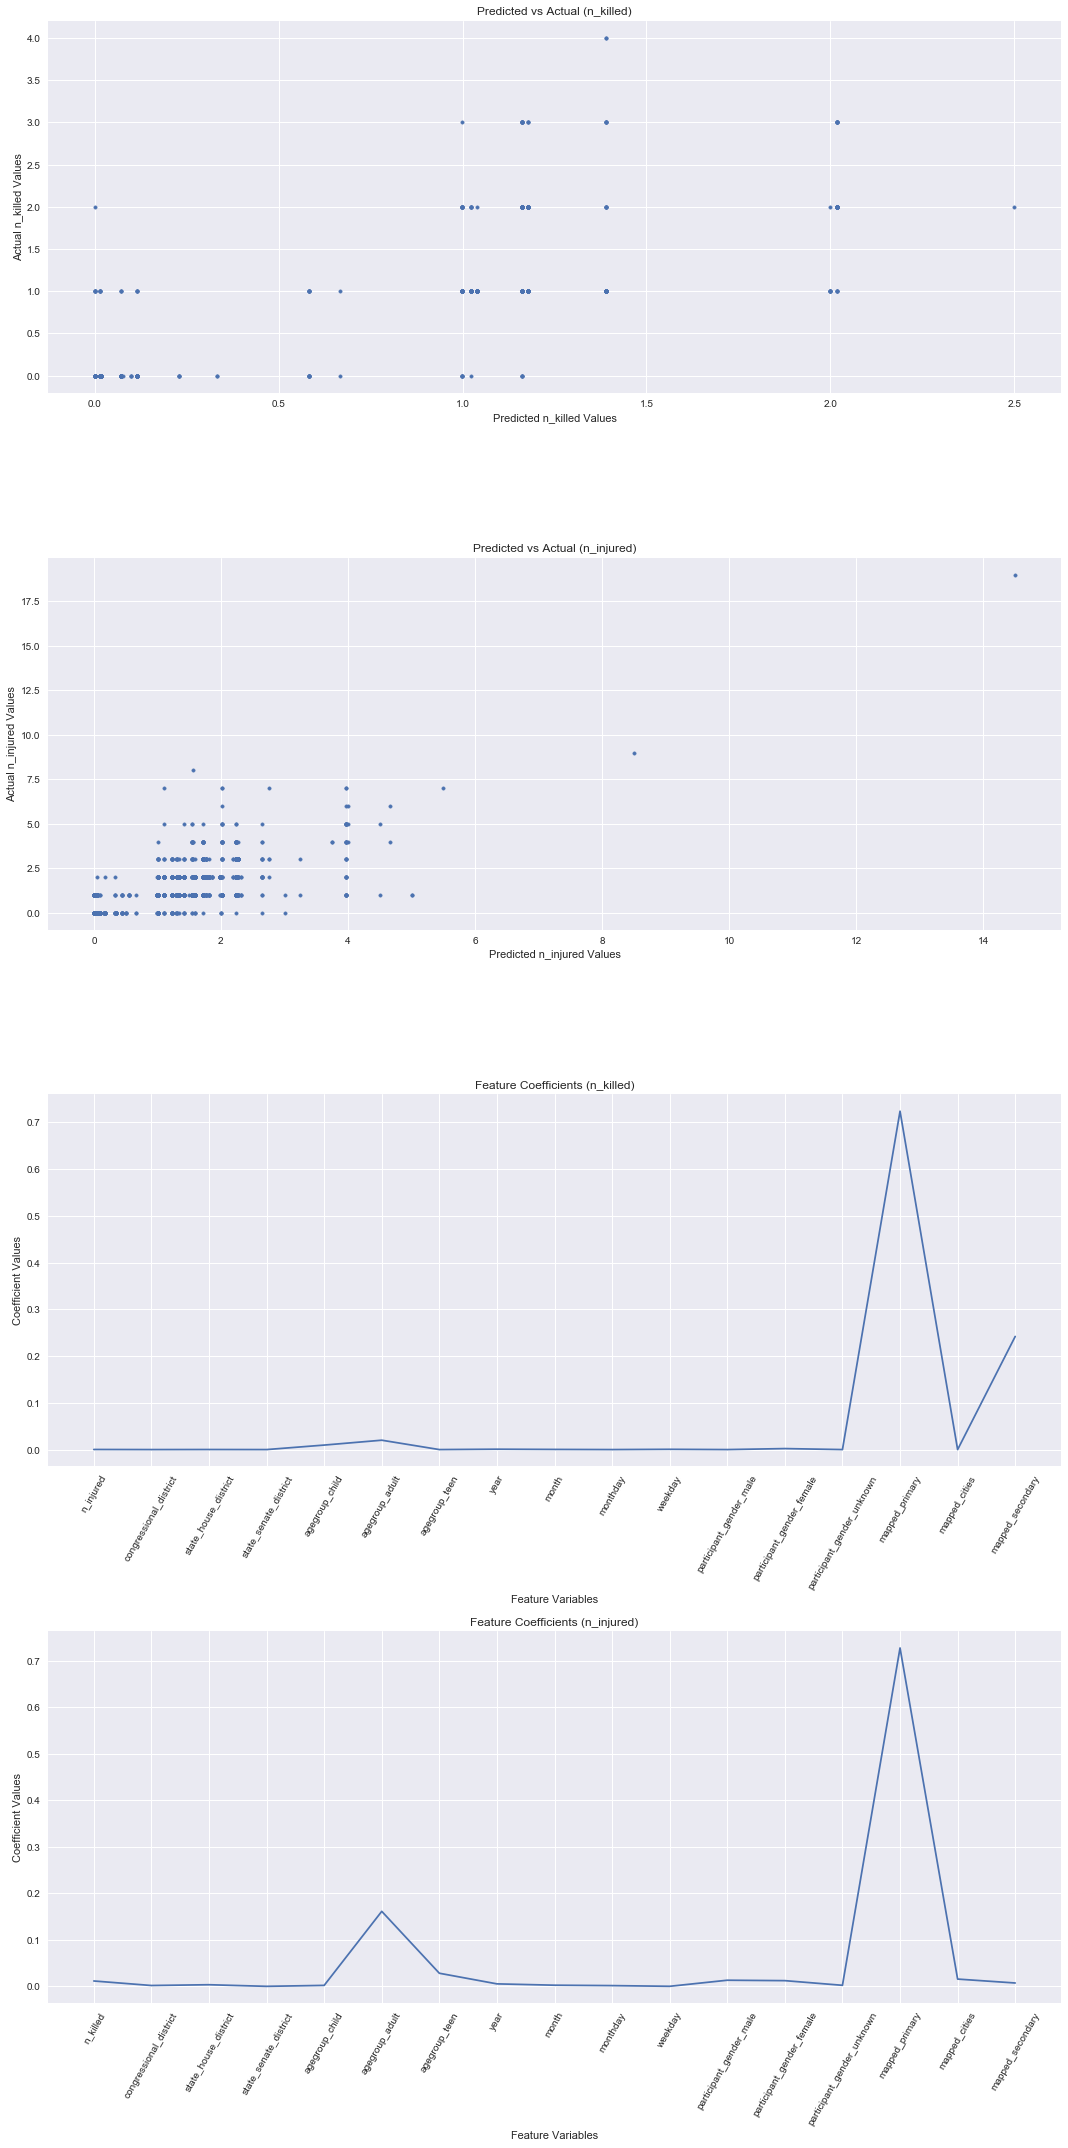

In [20]:
fig = plt.figure(figsize = (15,30))
_ = plt.subplot(4,1,1)
_ = plt.scatter(y_pred,y_test, marker = '.')
_ = plt.xlabel('Predicted n_killed Values')
_ = plt.ylabel('Actual n_killed Values')
_ = plt.title('Predicted vs Actual (n_killed)')

# Do the same for n_injured
_ = plt.subplot(4,1,2)
_ = plt.scatter(y_pred2,y_test2, marker = '.')
_ = plt.xlabel('Predicted n_injured Values')
_ = plt.ylabel('Actual n_injured Values')
_ = plt.title('Predicted vs Actual (n_injured)')

# Plot the coefficients 
tree_coef = best_tree.named_steps['tree'].feature_importances_
_ = plt.subplot(4,1,3)
_ = plt.plot(range(len(X_col)),tree_coef)
_ = plt.xticks(range(len(X_col)),X_col,rotation=60)
_ = plt.xlabel('Feature Variables')
_ = plt.ylabel('Coefficient Values')
_ = plt.title('Feature Coefficients (n_killed)')

# Do the same for n_injured
tree_coef2 = best_tree2.named_steps['tree'].feature_importances_
_ = plt.subplot(4,1,4)
_ = plt.plot(range(len(X2_col)),tree_coef2)
_ = plt.xticks(range(len(X2_col)),X2_col,rotation=60)
_ = plt.xlabel('Feature Variables')
_ = plt.ylabel('Coefficient Values')
_ = plt.title('Feature Coefficients (n_injured)')

_ = plt.tight_layout()

- For *n_killed*, the r-squared and RMSE scores have greatly improved using Decision Trees compared to the regression methods. The best results using the regressors was 0.3834 R-Squared and 0.4 RMSE using the Linear Regressor. Using the Decision Tree with RandomizedSearchCV, however, resulted in a 0.9086 R-Squared score and 0.1518 RMSE. 


- The predicted vs actual plot shows that there are no longer any negative values and there are fewer deviations (more space in between the points). However, it still does a poor job of predicting outliers (values greater than 2). 


- As for the feature coefficients plot, the decision tree put a significant amount of weight on the incident characteristics while putting very little weight elsewhere. This may be the main reason why there was such an enormous change in the r-squared/RMSE. 


- For *n_injured*, the R-Squared and RMSE scores have also improved using Decision Trees, but not as much as n_killed. The best results using the regressors was 0.4931 R-Squared and 0.5521 RMSE. It jumped to 0.7457 R-Squared and 0.3944 RMSE after using the Decision Tree. 


- The predicted vs actual plot shows no more negative values but only shows 2 values greater than 6, which is probably the reason why it did not have as big of an improvement as n_killed. Outliers make this model inefficient for n_injured.


- Like n_killed, the feature coefficients plot for n_injured shows that the Decision Tree model put the most weight on the primary characteristics feature. However, what's different is the fact that the secondary characteristics feature has actually gone down compared to the linear regression models. The agegroup_adult feature has almost 0.2 as its coefficient value, showing a more prominent role in this model.

**5. Using the Random Forest Ensemble**

Finally, let's use the **Random Forest** algorithm, which is an ensemble method which uses multiple decision trees. Each tree is built from a sample drawn with replacement (ex. a bootstrap sample) from the training set.

In [21]:
steps = [('scaler', StandardScaler()), ('rf', RandomForestRegressor())]
pipeline = Pipeline(steps)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 6)
    
n_estimators = range(80,101)
max_depth = range(1,51)
min_samples_split = range(2,11)
min_samples_leaf = range(1,5)
bootstrap = [True, False]
param_grid = {'rf__n_estimators': n_estimators,
              'rf__max_depth': max_depth,
              'rf__min_samples_split': min_samples_split,
              'rf__min_samples_leaf': min_samples_leaf,
              'rf__bootstrap': bootstrap
    }
rscv = RandomizedSearchCV(pipeline, param_grid, n_iter = 20, scoring = 'r2', cv = 10, n_jobs = -1, random_state =7)
rscv.fit(X_train, y_train)
    
print('The best score is (n_killed):{0:.4f}'.format(rscv.best_score_))
print('The best parameters are (n_killed):',rscv.best_params_)

# Do the same for n_injured
steps = [('scaler', StandardScaler()), ('rf', RandomForestRegressor())]
pipeline2 = Pipeline(steps)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size = 0.3, random_state = 6)
    
n_estimators = range(80,101)
max_depth = range(1,51)
min_samples_split = range(2,11)
min_samples_leaf = range(1,5)
bootstrap = [True, False]
param_grid = {'rf__n_estimators': n_estimators,
              'rf__max_depth': max_depth,
              'rf__min_samples_split': min_samples_split,
              'rf__min_samples_leaf': min_samples_leaf,
              'rf__bootstrap': bootstrap
    }
rscv2 = RandomizedSearchCV(pipeline2, param_grid, n_iter = 20, scoring = 'r2', cv = 10, n_jobs = -1, random_state =7)
rscv2.fit(X_train2, y_train2)
    
print('\nThe best score is (n_injured):{0:.4f}'.format(rscv2.best_score_))
print('The best parameters are (n_injured):',rscv2.best_params_)

The best score is (n_killed):0.9059
The best parameters are (n_killed): {'rf__n_estimators': 89, 'rf__min_samples_split': 9, 'rf__min_samples_leaf': 4, 'rf__max_depth': 26, 'rf__bootstrap': True}

The best score is (n_injured):0.7794
The best parameters are (n_injured): {'rf__n_estimators': 91, 'rf__min_samples_split': 9, 'rf__min_samples_leaf': 1, 'rf__max_depth': 15, 'rf__bootstrap': True}


In [22]:
best_rf = rscv.best_estimator_
y_pred = best_rf.predict(X_test)
print('\nR-squared (n_killed): {0:.4f}'.format(best_rf.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print("Root Mean Squared Error (n_killed): {0:.4f}".format(rmse))
cv_scores = cross_val_score(best_rf,X,y,cv=10)
print("Average 10-Fold CV Score (n_killed): {0:.4f}".format(np.mean(cv_scores)))

# Do the same for n_injured
best_rf2 = rscv2.best_estimator_
y_pred2 = best_rf2.predict(X_test2)
print('\nR-squared (n_injured): {0:.4f}'.format(best_rf2.score(X_test2, y_test2)))
rmse2 = np.sqrt(mean_squared_error(y_test2,y_pred2))
print("Root Mean Squared Error (n_injured): {0:.4f}".format(rmse2))
cv_scores2 = cross_val_score(best_rf2,X2,y2,cv=10)
print("Average 10-Fold CV Score (n_injured): {0:.4f}".format(np.mean(cv_scores2)))


R-squared (n_killed): 0.9033
Root Mean Squared Error (n_killed): 0.1559
Average 10-Fold CV Score (n_killed): 0.9039

R-squared (n_injured): 0.7842
Root Mean Squared Error (n_injured): 0.3574
Average 10-Fold CV Score (n_injured): 0.7791


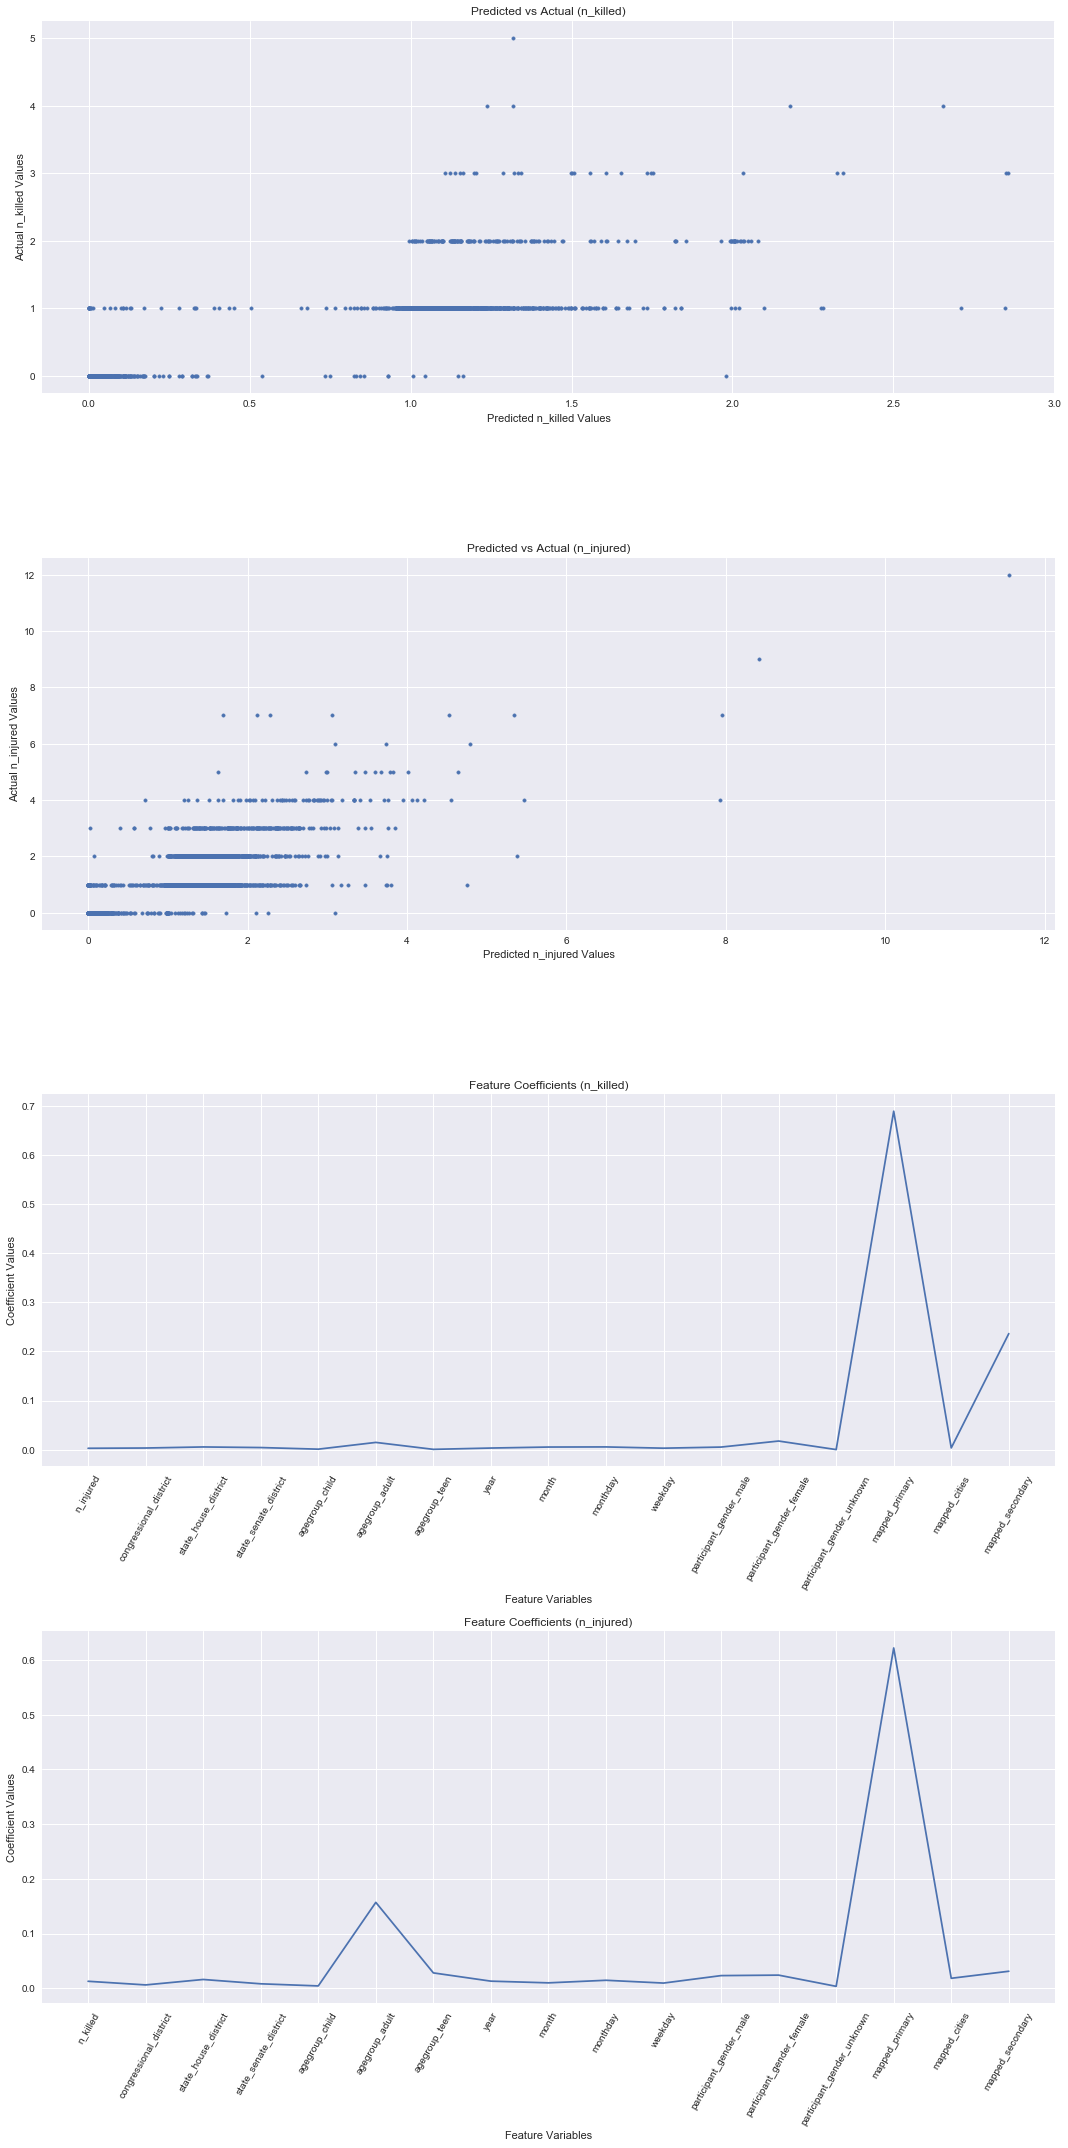

In [23]:
fig = plt.figure(figsize = (15,30))
_ = plt.subplot(4,1,1)
_ = plt.scatter(y_pred,y_test, marker = '.')
_ = plt.xlabel('Predicted n_killed Values')
_ = plt.ylabel('Actual n_killed Values')
_ = plt.title('Predicted vs Actual (n_killed)')

# Do the same for n_injured
_ = plt.subplot(4,1,2)
_ = plt.scatter(y_pred2,y_test2, marker = '.')
_ = plt.xlabel('Predicted n_injured Values')
_ = plt.ylabel('Actual n_injured Values')
_ = plt.title('Predicted vs Actual (n_injured)')

# Plot the coefficients 
rf_coef = best_rf.named_steps['rf'].feature_importances_
_ = plt.subplot(4,1,3)
_ = plt.plot(range(len(X_col)),rf_coef)
_ = plt.xticks(range(len(X_col)),X_col,rotation=60)
_ = plt.xlabel('Feature Variables')
_ = plt.ylabel('Coefficient Values')
_ = plt.title('Feature Coefficients (n_killed)')

# Do the same for n_injured
rf_coef2 = best_rf2.named_steps['rf'].feature_importances_
_ = plt.subplot(4,1,4)
_ = plt.plot(range(len(X2_col)),rf_coef2)
_ = plt.xticks(range(len(X2_col)),X2_col,rotation=60)
_ = plt.xlabel('Feature Variables')
_ = plt.ylabel('Coefficient Values')
_ = plt.title('Feature Coefficients (n_injured)')

_ = plt.tight_layout()

- For *n_killed*, using random forest had a slightly worse r-squared (0.9027 vs 0.9086) and RMSE (0.1563 vs 0.1518) scores than using the decision tree model.


- Looking at the predicted vs actual plot, we can see that it has greater variance in the range of points compared to the Decision Tree model. For the feature coefficients plot, it is nearly identical to that of the decision tree model, showing that the best predictor features are indeed the incident characteristics. Compared to the Decision Tree model, the random forest model puts more weight on participant_gender_female.


- For *n_injured*, the Random Forest model showed a small improvement over the Decision Tree model. Its R-Squared score increased to 0.7828 and its RMSE dropped to 0.3584.


- There is now a greater distribution of points in the predicted vs actual plot, similar to what happened to n_killed after using the Random Forest model to generate predictions. There are also a few more outliers as indicated by the fact that there are 5 predicted points whose values are greater than 6. For the feature coefficients plot, it is about the same as the plot from the decision tree model. 

**6. Optimizing the model by removing outliers and noisy features**

- One of the reoccuring issues that's been on-going with all the models has been the outliers in the data. To create a better algorithm for predicting n_killed and n_injured, we will need to drop the outliers to prevent overfitting. First, let's see exactly what the threshold for outliers is by using at the probability distribution of the number of people killed and injured.

In [24]:
# Create a list of all the n_killed values and use a for-loop function to create a new list that contains the count and its
# proportion of total incidents 
outlier_test = [0,1,2,3,4,5,8]
outlier_ = []
outlier_list = []
outlier_perc = []
for x in outlier_test:
    a = len(df[df['n_killed']==x])
    b = a/len(df)
    b = round(b,4)
    outlier_.append(x)
    outlier_list.append(a)
    outlier_perc.append(b)
outlier_dict = {'n_killed value':outlier_, 'Count':outlier_list, 'Proportion':outlier_perc}
pd.DataFrame(outlier_dict).set_index('n_killed value')

,Count,Proportion
n_killed value,,
0,26357,0.7377
1,8697,0.2434
2,579,0.0162
3,75,0.0021
4,13,0.0004
5,5,0.0001
8,1,0.0000


- Less than 99.7% of the incidents result in 3 or more deaths. This is the clear threshold for outliers because of its miniscule probability.

In [25]:
# Repeat the same process for n_injured
outlier_test2 = list(range(0,20))
outlier_2 = []
outlier_list2 = []
outlier_perc2 = []
for x in outlier_test2:
    a = len(df[df['n_injured']==x])
    b = a/len(df)
    b = round(b, 4)
    outlier_2.append(x)
    outlier_list2.append(a)
    outlier_perc2.append(b)
outlier_dict2 = {'n_injured value':outlier_2, 'Count':outlier_list2, 'Proportion':outlier_perc2}
pd.DataFrame(outlier_dict2).set_index('n_injured value')

,Count,Proportion
n_injured value,,
0,13462,0.3768
1,18598,0.5206
2,2767,0.0774
3,630,0.0176
4,164,0.0046
5,63,0.0018
6,15,0.0004
7,16,0.0004
8,4,0.0001


- Less than 99.2% of incidents result in 4 or more deaths. This should be the threshold for outliers for n_injured.


- Let's drop these incidents where there are 3+ deaths or 4+ injuries.

In [26]:
# Grab the index of the outliers
outlier_index = df[(df['n_killed']>2) | (df['n_injured']>3)].index
# Drop the incidents using the index
new_df = df.drop(outlier_index)

- To further improve the model, let's drop the features whose coefficients have little to no impact in predicting the response variables. Otherwise they would simply create "noise" in the model and make it less efficient.

In [27]:
# Create a dataframe containing the features and their respective coefficient values based on the random forest models
coef_df = pd.DataFrame(data = [X_col, np.round_(rf_coef, 4)]).transpose()
coef_df.columns = ['Features', 'Coefficient Values']
coef_df.sort_values(by='Coefficient Values', ascending = False)

,Features,Coefficient Values
14,mapped_primary,0.6889
16,mapped_secondary,0.2362
12,participant_gender_female,0.0175
5,agegroup_adult,0.0147
9,monthday,0.0055
2,state_house_district,0.0054
8,month,0.0053
11,participant_gender_male,0.0052
3,state_senate_district,0.0042
15,mapped_cities,0.0035


- Based on the table of the random forest-generated feature coefficients for n_killed, we can see that mapped_primary, mapped_secondary, agegroup_adult, and participant_gender_female are the only features that have a seemingly, tangible effect in the model. 


- It should be noted that the coefficient values may not have a great impact on the number of people killed. For example, for every 1 unit increase for agegroup_adult, there is only a 0.0148 increase in n_killed. Much of this has to do with the fact that for over 96% of shooting incidents, there have only been 1 or 0 deaths. Thus, it makes sense why a 1 unit increase of a feature variable may not have a sizeable impact.


- Let's keep these and disregard the rest.

In [28]:
# Repeat the same process for n_injured
coef_df = pd.DataFrame(data = [X2_col, np.round_(rf_coef2, 4)]).transpose()
coef_df.columns = ['Features', 'Coefficient Values']
coef_df.sort_values(by='Coefficient Values', ascending = False)

,Features,Coefficient Values
14,mapped_primary,0.6221
5,agegroup_adult,0.1569
16,mapped_secondary,0.031
6,agegroup_teen,0.028
12,participant_gender_female,0.0239
11,participant_gender_male,0.023
15,mapped_cities,0.0181
2,state_house_district,0.016
9,monthday,0.0145
7,year,0.0129


- As for n_injured, there are more features that have a coefficient value greater than 0.01 compared to n_killed, which only had 4. For this case, let's keep all the features that had a coefficient value greater than or equal to 0.01, which would be the top 12 features shown in the dataframe above.


- Next let's select the chosen features and the same response variables as before to optimize our models.

In [29]:
# Select feature variables and store them as a numpy array
nX = new_df[['agegroup_adult','mapped_primary','mapped_secondary','participant_gender_female'
       ]]
# Convert to float to avoid DataConversion warning
nX = nX.astype(float)
# Extract list of columns
nX_col = nX.columns
nX = nX.values
nX2 = new_df[['n_killed', 
        'state_house_district',
        'agegroup_adult','agegroup_teen',
        'year','month','monthday',
        'participant_gender_male','participant_gender_female',
        'mapped_primary','mapped_cities','mapped_secondary'
       ]]
nX2 = nX2.astype(float)
nX2_col = nX2.columns
nX2 =  nX2.values
# Select response variables and store them as a numpy array
ny = new_df['n_killed'].values
ny2 = new_df['n_injured'].values

- Finally, let's create new Linear Regression, Decision Tree and Random Forest models using our optimized data.

In [30]:
steps = [('scaler', StandardScaler()), ('tree', DecisionTreeRegressor())]
pipeline = Pipeline(steps)
X_train, X_test, y_train, y_test = train_test_split(nX, ny, test_size = 0.3, random_state = 35)

# Define the parameter values that will be randomly searched
max_depth = range(1,51)
min_samples_split = range(2,5)
min_samples_leaf = [1, 2]
# Create the parameter grid
param_grid = {'tree__max_depth': max_depth,
              'tree__min_samples_split': min_samples_split,
              'tree__min_samples_leaf': min_samples_leaf}
# Instantiate random search
rscv = RandomizedSearchCV(pipeline, param_grid, n_iter = 20, scoring = 'r2', n_jobs = -1, cv = 10, random_state = 5)
# Fit the training data into the model
rscv.fit(X_train, y_train)
    
# Print the best score and its respective parameters
print('The best score is (n_killed):{0:.4f}'.format(rscv.best_score_))
print('The best parameters are (n_killed):',rscv.best_params_)

# Do the same for n_injured
steps = [('scaler', StandardScaler()), ('tree', DecisionTreeRegressor())]
pipeline2 = Pipeline(steps)
X_train2, X_test2, y_train2, y_test2 = train_test_split(nX2, ny2, test_size = 0.3, random_state = 35)
max_depth = range(1,51)
min_samples_split = range(2,5)
min_samples_leaf = [1, 2]
param_grid = {'tree__max_depth': max_depth,
              'tree__min_samples_split': min_samples_split,
              'tree__min_samples_leaf': min_samples_leaf}
rscv2 = RandomizedSearchCV(pipeline2, param_grid, n_iter = 20, scoring = 'r2', n_jobs = -1, cv = 10, random_state = 5)
rscv2.fit(X_train2, y_train2)
print('\nThe best score is (n_injured):{0:.4f}'.format(rscv2.best_score_))
print('The best parameters are (n_injured):',rscv2.best_params_)

The best score is (n_killed):0.9345
The best parameters are (n_killed): {'tree__min_samples_split': 4, 'tree__min_samples_leaf': 2, 'tree__max_depth': 40}

The best score is (n_injured):0.7811
The best parameters are (n_injured): {'tree__min_samples_split': 3, 'tree__min_samples_leaf': 1, 'tree__max_depth': 8}


In [31]:
# Now use the best parameters to make predictions using the test data and compute the r-squared/RMSE
best_tree = rscv.best_estimator_
y_pred = best_tree.predict(X_test)
print('R-squared (n_killed): {0:.4f}'.format(best_tree.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print("Root Mean Squared Error (n_killed): {0:.4f}".format(rmse))
cv_scores = cross_val_score(best_tree,nX,ny,cv=10)
print("Average 10-Fold CV Score (n_killed): {0:.4f}".format(np.mean(cv_scores)))

# Do the same for n_injured
best_tree2 = rscv2.best_estimator_
y_pred2 = best_tree2.predict(X_test2)
print('\nR-squared (n_injured): {0:.4f}'.format(best_tree2.score(X_test2, y_test2)))
rmse2 = np.sqrt(mean_squared_error(y_test2,y_pred2))
print("Root Mean Squared Error (n_injured): {0:.4f}".format(rmse2))
cv_scores2 = cross_val_score(best_tree,nX2,ny2,cv=10)
print("Average 10-Fold CV Score (n_injured): {0:.4f}".format(np.mean(cv_scores2)))

R-squared (n_killed): 0.9325
Root Mean Squared Error (n_killed): 0.1258
Average 10-Fold CV Score (n_killed): 0.9330

R-squared (n_injured): 0.7776
Root Mean Squared Error (n_injured): 0.3143
Average 10-Fold CV Score (n_injured): 0.6621


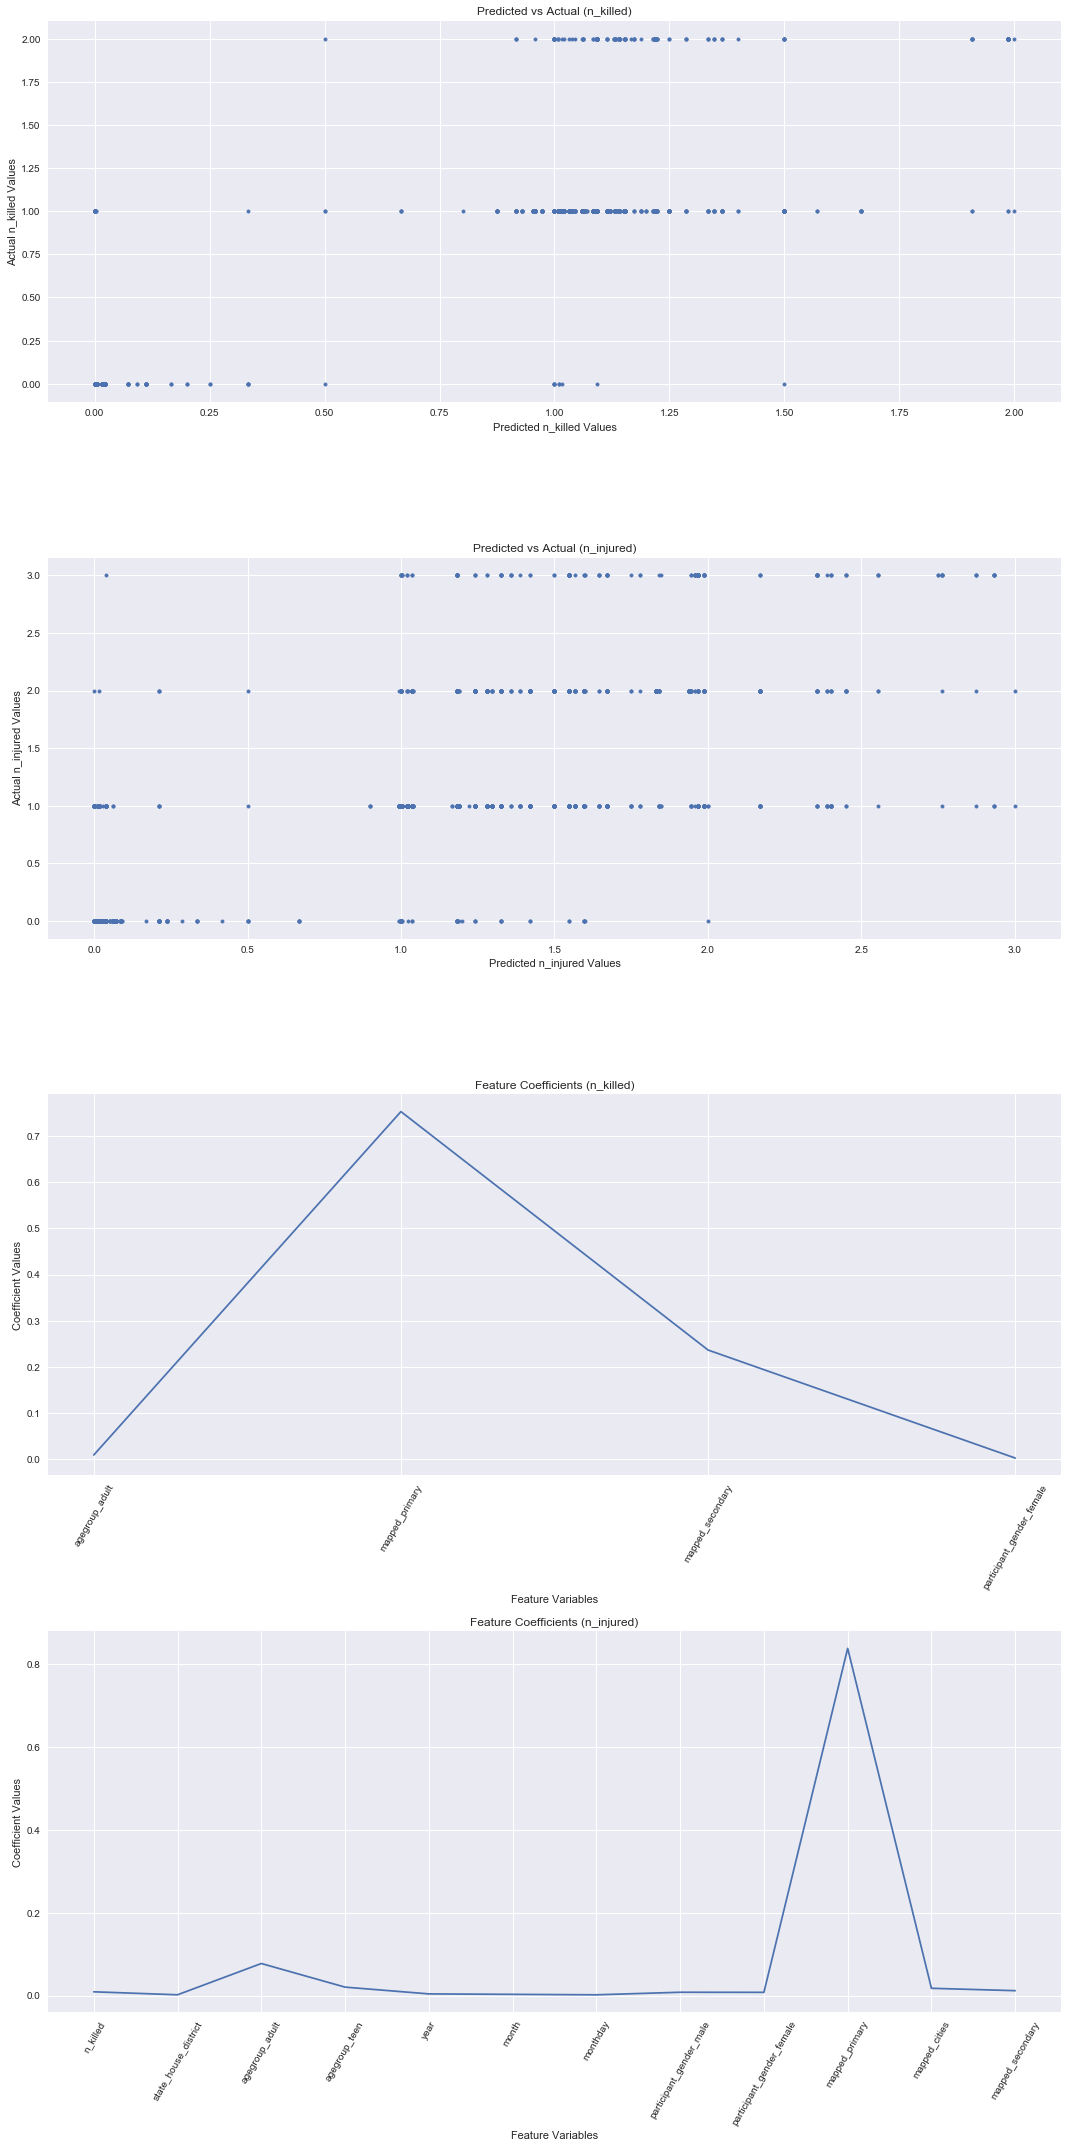

In [32]:
fig = plt.figure(figsize = (15,30))
_ = plt.subplot(4,1,1)
_ = plt.scatter(y_pred,y_test, marker = '.')
_ = plt.xlabel('Predicted n_killed Values')
_ = plt.ylabel('Actual n_killed Values')
_ = plt.title('Predicted vs Actual (n_killed)')

# Do the same for n_injured
_ = plt.subplot(4,1,2)
_ = plt.scatter(y_pred2,y_test2, marker = '.')
_ = plt.xlabel('Predicted n_injured Values')
_ = plt.ylabel('Actual n_injured Values')
_ = plt.title('Predicted vs Actual (n_injured)')

# Plot the coefficients 
tree_coef = best_tree.named_steps['tree'].feature_importances_
_ = plt.subplot(4,1,3)
_ = plt.plot(range(len(nX_col)),tree_coef)
_ = plt.xticks(range(len(nX_col)),nX_col,rotation=60)
_ = plt.xlabel('Feature Variables')
_ = plt.ylabel('Coefficient Values')
_ = plt.title('Feature Coefficients (n_killed)')

# Do the same for n_injured
tree_coef2 = best_tree2.named_steps['tree'].feature_importances_
_ = plt.subplot(4,1,4)
_ = plt.plot(range(len(nX2_col)),tree_coef2)
_ = plt.xticks(range(len(nX2_col)),nX2_col,rotation=60)
_ = plt.xlabel('Feature Variables')
_ = plt.ylabel('Coefficient Values')
_ = plt.title('Feature Coefficients (n_injured)')

_ = plt.tight_layout()

- For *n_killed*, the optimized Decision Tree model has shown improvement in both R-squared (0.9325 with optimization vs 0.9086 without) and RMSE (0.1258 vs 0.1518). 


- Looking at the predicted vs actual plot, this model has become better at correctly predicting when the number of people killed is 0 but still needs to improve on correctly predicting when the true value is greater than 0. The model also put more weight on the mapped_primary feature moreso than before as its coefficient value has increased to over 0.7. 


- For *n_injured*, the optimized Decision Tree model showed improvement in R-Squared (0.7797 with optimization vs 0.7457) and in RMSE (0.3128 vs 3944).


- The predicted vs actual plot shows that the model works best when predicting number of people injured is actually 0, but does a poor job at correctly predicting incidents where the number is greater than 0. The feature coefficients plot shows about the same plot as without the optimization, although it has put more weight on the mapped_primary feature. 


- Next, let's try using the Random Forest Regressor.

In [33]:
steps = [('scaler', StandardScaler()), ('rf', RandomForestRegressor())]
pipeline = Pipeline(steps)
X_train, X_test, y_train, y_test = train_test_split(nX, ny, test_size = 0.3, random_state = 6)
n_estimators = range(80,101)
max_depth = range(1,51)
min_samples_split = range(2,11)
min_samples_leaf = range(1,5)
bootstrap = [True, False]
param_grid = {'rf__n_estimators': n_estimators,
              'rf__max_depth': max_depth,
              'rf__min_samples_split': min_samples_split,
              'rf__min_samples_leaf': min_samples_leaf,
              'rf__bootstrap': bootstrap
    }
rscv = RandomizedSearchCV(pipeline, param_grid, n_iter = 20, scoring = 'r2', cv = 10, n_jobs = -1, random_state =7)
rscv.fit(X_train, y_train)
print('The best score is (n_killed):{0:.4f}'.format(rscv.best_score_))
print('The best parameters are (n_killed):',rscv.best_params_)

# Do the same for n_injured
steps = [('scaler', StandardScaler()), ('rf', RandomForestRegressor())]
pipeline2 = Pipeline(steps)
X_train2, X_test2, y_train2, y_test2 = train_test_split(nX2, ny2, test_size = 0.3, random_state = 6)
n_estimators = range(80,101)
max_depth = range(1,51)
min_samples_split = range(2,11)
min_samples_leaf = range(1,5)
bootstrap = [True, False]
param_grid = {'rf__n_estimators': n_estimators,
              'rf__max_depth': max_depth,
              'rf__min_samples_split': min_samples_split,
              'rf__min_samples_leaf': min_samples_leaf,
              'rf__bootstrap': bootstrap
    }
rscv2 = RandomizedSearchCV(pipeline2, param_grid, n_iter = 20, scoring = 'r2', cv = 10, n_jobs = -1, random_state =7)
rscv2.fit(X_train2, y_train2)
print('\nThe best score is (n_injured):{0:.4f}'.format(rscv2.best_score_))
print('The best parameters are (n_injured):',rscv2.best_params_)

The best score is (n_killed):0.9370
The best parameters are (n_killed): {'rf__n_estimators': 91, 'rf__min_samples_split': 3, 'rf__min_samples_leaf': 2, 'rf__max_depth': 35, 'rf__bootstrap': True}

The best score is (n_injured):0.8061
The best parameters are (n_injured): {'rf__n_estimators': 91, 'rf__min_samples_split': 9, 'rf__min_samples_leaf': 1, 'rf__max_depth': 15, 'rf__bootstrap': True}


In [34]:
best_rf = rscv.best_estimator_
y_pred = best_rf.predict(X_test)
print('\nR-squared (n_killed): {0:.4f}'.format(best_rf.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print("Root Mean Squared Error (n_killed): {0:.4f}".format(rmse))
cv_scores = cross_val_score(best_rf,nX,ny,cv=10)
print("Average 10-Fold CV Score (n_killed): {0:.4f}".format(np.mean(cv_scores)))

# Do the same for n_injured
best_rf2 = rscv2.best_estimator_
y_pred2 = best_rf2.predict(X_test2)
print('\nR-squared (n_injured): {0:.4f}'.format(best_rf2.score(X_test2, y_test2)))
rmse2 = np.sqrt(mean_squared_error(y_test2,y_pred2))
print("Root Mean Squared Error (n_injured): {0:.4f}".format(rmse2))
cv_scores2 = cross_val_score(best_rf2,nX2,ny2,cv=10)
print("Average 10-Fold CV Score (n_injured): {0:.4f}".format(np.mean(cv_scores2)))


R-squared (n_killed): 0.9367
Root Mean Squared Error (n_killed): 0.1206
Average 10-Fold CV Score (n_killed): 0.9348

R-squared (n_injured): 0.8149
Root Mean Squared Error (n_injured): 0.2920
Average 10-Fold CV Score (n_injured): 0.7995


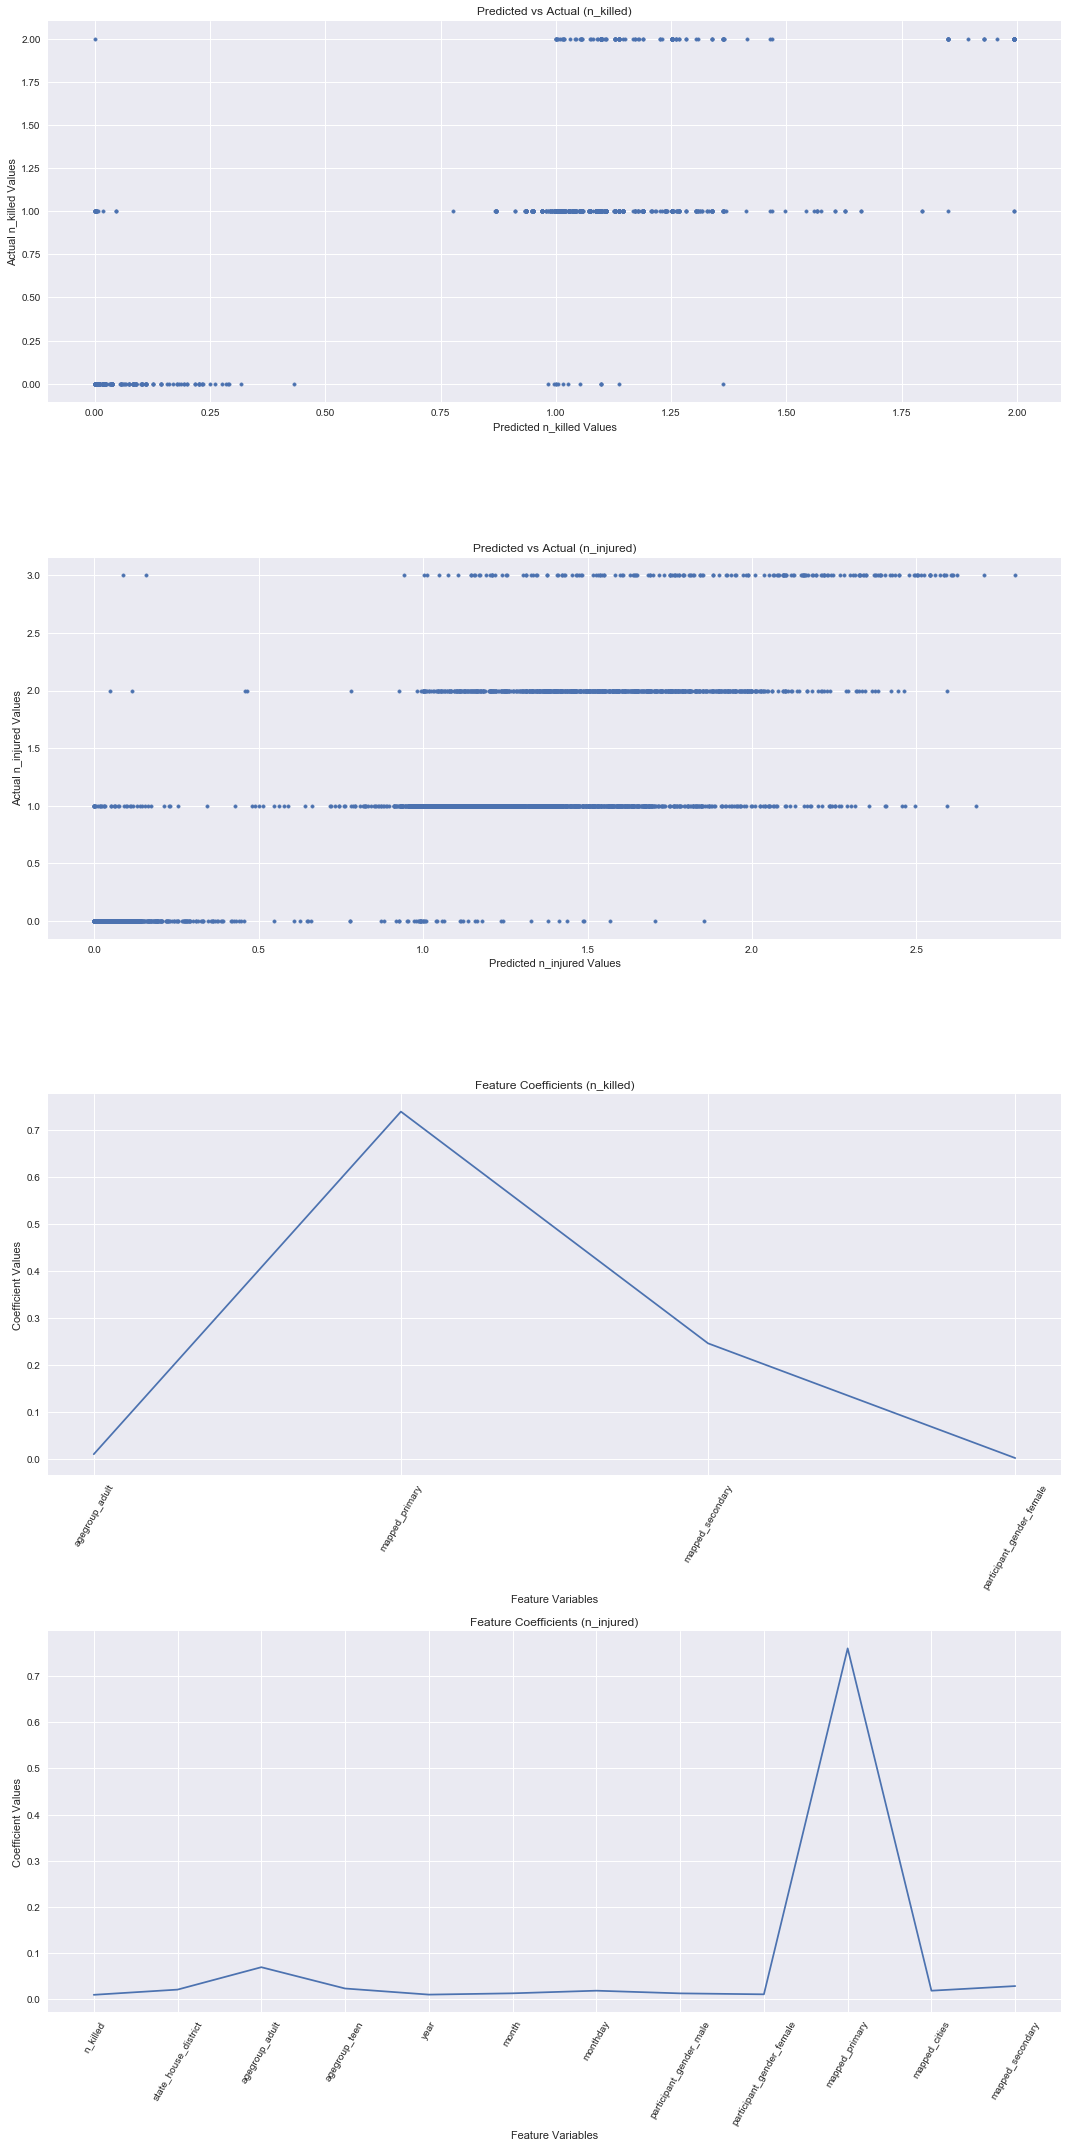

In [35]:
fig = plt.figure(figsize = (15,30))
_ = plt.subplot(4,1,1)
_ = plt.scatter(y_pred,y_test, marker = '.')
_ = plt.xlabel('Predicted n_killed Values')
_ = plt.ylabel('Actual n_killed Values')
_ = plt.title('Predicted vs Actual (n_killed)')

# Do the same for n_injured
_ = plt.subplot(4,1,2)
_ = plt.scatter(y_pred2,y_test2, marker = '.')
_ = plt.xlabel('Predicted n_injured Values')
_ = plt.ylabel('Actual n_injured Values')
_ = plt.title('Predicted vs Actual (n_injured)')

# Plot the coefficients 
rf_coef = best_rf.named_steps['rf'].feature_importances_
_ = plt.subplot(4,1,3)
_ = plt.plot(range(len(nX_col)),rf_coef)
_ = plt.xticks(range(len(nX_col)),nX_col,rotation=60)
_ = plt.xlabel('Feature Variables')
_ = plt.ylabel('Coefficient Values')
_ = plt.title('Feature Coefficients (n_killed)')

# Do the same for n_injured
rf_coef2 = best_rf2.named_steps['rf'].feature_importances_
_ = plt.subplot(4,1,4)
_ = plt.plot(range(len(nX2_col)),rf_coef2)
_ = plt.xticks(range(len(nX2_col)),nX2_col,rotation=60)
_ = plt.xlabel('Feature Variables')
_ = plt.ylabel('Coefficient Values')
_ = plt.title('Feature Coefficients (n_injured)')

_ = plt.tight_layout()

- For *n_killed*, the optimized Random Forest model has shown improvement in both R-squared (0.9368 with optimization vs 0.9023 without) and RMSE (0.1205 vs 0.1566). It also has better results than the optimized Decision Tree model.


- As was the case for the optimized Decision Tree model, the optimized Random Forest model does a better job at predicting cases where there were no deaths but is not efficient for cases where there's at least 1 death. However, it definitely is more accurate than the first iteration of the random forest model without optimization due to the fact that there are no longer outliers. The feature coefficients plot also looks pretty similar to that of the optimized Decision Tree model.


- For *n_injured*, the optimized Random Forest model showed improvement in R-Squared (0.8149 with optimization vs 0.7822) and in RMSE (0.2919 vs 3589). Just like n_killed, this model has proven to be more successful for n_injured than the Decision Tree model.


- The predicted vs actual plot shows a number of points that spread out between 1 and 3 when the true value is 1. This indicates the uneffectiveness of this model but the fact that it received higher R-Squared and RMSE scores means that it has a greater concentration of points in the regions with correctly predicted values. For example, while there are many predicted values between 1 and 2 when the true value is 1, the majority of them are actually close to 1. 

**7. Model Conclusion**

As a result of testing various different models and removing outliers to improve the results, the optimized Random Forest classifier has proven to be the most effective model for predicting the number of people killed *and* the number of people injured in gun incidents. The most influential feature variable has been the primary characteristics (as represented by mapped_primary for feature selection) and this is because the 'Shot - Wounded/Injured' and 'Shot - Dead' categories are make it very clear whether the incident resulted in injury or death. For the same reason, the secondary characteristics (represented by mapped_secondary) are also very impactful. The other variables did not have as strong of an impact which shows that overall, only the characteristic incidents prove be the only effective predictors of the number of people killed.

In [36]:
model_dict = {
    'Model for n_killed':['Base-line','Linear Regression','Linear Regression w/ Lasso', 'Linear Regression w/Ridge',
            'Decision Tree', 'Random Forest', 'Decision Tree w/ Optimization', 'Random Forest w/ Optimization'
            ],
    'R-Squared':[-0.0001, 0.3834, 0.3778, 0.3584, 0.9085, 0.9023, 0.9325, 0.9368],
    'RMSE':[0.5067, 0.3924, 0.3911, 0.3959, 0.1518, 0.1566, 0.1258, 0.1205]
}
pd.DataFrame(model_dict).set_index('Model for n_killed').sort_values(by='R-Squared', ascending = False)

,R-Squared,RMSE
Model for n_killed,,
Random Forest w/ Optimization,0.9368,0.1205
Decision Tree w/ Optimization,0.9325,0.1258
Decision Tree,0.9085,0.1518
Random Forest,0.9023,0.1566
Linear Regression,0.3834,0.3924
Linear Regression w/ Lasso,0.3778,0.3911
Linear Regression w/Ridge,0.3584,0.3959
Base-line,-0.0001,0.5067


In [37]:
model_dict2 = {
    'Model for n_injured':['Base-line','Linear Regression','Linear Regression w/ Lasso', 'Linear Regression w/Ridge',
            'Decision Tree', 'Random Forest', 'Decision Tree w/ Optimization', 'Random Forest w/ Optimization'
            ],
    'R-Squared':[-0.00002,0.4746, 0.4825, 0.4931, 0.7462, 0.7822, 0.7771, 0.8149],
    'RMSE':[0.7653, 0.5718, 0.5524, 0.5720, 0.3940, 0.3589, 0.3147, 0.2919]
}
pd.DataFrame(model_dict2).set_index('Model for n_injured').sort_values(by='R-Squared', ascending = False)

,R-Squared,RMSE
Model for n_injured,,
Random Forest w/ Optimization,0.81490,0.2919
Random Forest,0.78220,0.3589
Decision Tree w/ Optimization,0.77710,0.3147
Decision Tree,0.74620,0.3940
Linear Regression w/Ridge,0.49310,0.5720
Linear Regression w/ Lasso,0.48250,0.5524
Linear Regression,0.47460,0.5718
Base-line,-0.00002,0.7653
